In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import glob
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats as st
from scipy.stats import norm
import statsmodels.formula.api as sm
import datetime
import re
import shutil
import string
from __future__ import division, print_function

now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d_%H:%M")
month = now.strftime("%B")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
import sys
%matplotlib inline
%load_ext rpy2.ipython

## Importing Data From Each Trial, For Each Participant

In [ ]:
# load the csv files into pandas
sleep_df = pd.DataFrame()

# starting dir
start_dir = os.getcwd() + "/data/"

# Get a list of dirs
participant_dirs = os.listdir( start_dir )

# for each folder in the glob
for participant in participant_dirs:
    # sanity check: make sure its a directory
    participant_path = start_dir + participant
    if os.path.isdir(participant_path):
        # for each csv in the folder
        part_glob = glob.glob( participant_path + "/*.csv" )

        # add to the table
        for csv in part_glob:
            df = pd.read_csv(csv)
            sleep_df = sleep_df.append(df)


# check to make sure that csv content is added to data frame
sleep_df.head()


In [ ]:
# get a list of all columns
cols = list(sleep_df)

# create a table with *only* the columns we want
sleep_columns = ['participant','stim1','stim2','correct','key_resp_2.keys','key_resp_9.keys','key_resp_9.corr','key_resp_9.rt','session']
sleep_df = sleep_df[sleep_columns]

print(start_dir)

# sanity chek
sleep_df.head()


In [ ]:
# remove Nan lines in order to make finding type and version less error prone
# we'll do this by removing the rows that have stim[1&&2] set to NaN
sleep_df = sleep_df[pd.notnull(sleep_df['stim1']) & pd.notnull(sleep_df['stim2'])]

sleep_df.head()

## Adding columns to indicate type, version

In [ ]:
# create a dataframe from the key file, try to do a table join SQLkinda thing
# you already know the path to the key
key_path = os.getcwd() + "/key/key.csv"
key_df = pd.read_csv(key_path)

# because we're going to use join, take out the columns you want
key_cols = ['stim1','stim2', 'notes_novword_2', 'TP_novword1','type','version']
key_df = key_df[key_cols]

key_df.head()



In [ ]:
## merge the two data frames on both the stim_1 and stim_2 values
join_df = pd.merge(sleep_df, key_df, on=['stim1', 'stim2'], how='outer')
join_df.sort_values('participant', inplace=True)
join_df.reset_index(drop=True, inplace=True)

In [ ]:
#sanity check

join_df.head(500)

In [ ]:
# before we can fix the correct column, we need to fix the mapping, i.e. convert the list vals to their ints
join_df['key_resp_2.keys'] = join_df['key_resp_2.keys'].map({"['1']": 1, "['2']": 2, 1: 1, 2: 2, '1': 1, '2': 2, 'None': 'None'})
join_df['key_resp_9.keys'] = join_df['key_resp_9.keys'].map({"['1']": 1, "['2']": 2, 1: 1, 2: 2, '1': 1, '2': 2, 'None': 'None'})

# for key_resp_9.rt, we need to extract the ints stuck in strings
# a little unstable, but here's what this does
# for all values in key_resp_9.rt, if its a string, assuming that it's a list in a string, extract and cast the value in the list to an int
join_df = join_df.rename(columns = {'key_resp_9.rt':'key_resp_9_rt'})
join_df['key_resp_9_rt'] = join_df.apply( lambda row: ( (float(row['key_resp_9_rt'][1:row['key_resp_9_rt'].find(',')]) if row['key_resp_9_rt'].find(',') > -1
                                                        else float(row['key_resp_9_rt'][1:-1]))
                                                           if isinstance( row['key_resp_9_rt'], str ) == True 
                                                           else row['key_resp_9_rt'] ), axis=1 )

# the correct condition is that each correct must be equal to its corresponding key value, unless its equal to 0
# rename 'key_resp_9.keys' to make indexing easier
join_df = join_df.rename(columns = {'key_resp_9.keys':'key_resp_9'})
join_df.loc[join_df.correct == join_df.key_resp_9, 'key_resp_9.corr'] = 1
join_df.loc[join_df.correct != join_df.key_resp_9, 'key_resp_9.corr'] = 0
join_df.loc[join_df.key_resp_9 == 'None', 'key_resp_9.corr'] = np.NaN

join_df.head(500)

In [ ]:
# Types for creating type_all column
types = {'three_1nov_1cong': 'all_three', 'three_2nov_2cong': 'all_three', 'three_2nov_1cong_1incong': 'all_three',
         'part_w': 'all_word_seg', 'non_w': 'all_word_seg', 'order_TP33': 'order', np.nan: np.nan}

# Create new column where the value for each row depends on the value for column type
join_df['type_all'] = join_df.apply(lambda row: types[row['type']], axis=1)

# DataFrame with type_all column added
join_df.head()


### Output data to csv

In [ ]:
join_df.to_csv('output.csv')

# Create pivot table for each session & version combination and merge together into one table

In [ ]:
# Dictionary used to create each grouping of columns depending on the session and version
# First tuple represents the sessions and the second tuple represents the versions. 
types = {'all_type': [(1, 2), (1, 2)], 's_all_v_1': [(1, 2), (1,)], 's_all_v_2': [(1, 2), (2,)],
         's_1_v_all': [(1,), (1, 2)], 's_2_v_all': [(2,), (1, 2)], 's_1_v_1': [(1,), (1,)], 's_1_v_2': [(1,), (2,)],
         's_2_v_1': [(2,), (1,)], 's_2_v_2': [(2,), (2,)]}

# Start off with a column of all participants
# Remove any duplicates so that each participant only appears once
sleep_df = join_df['participant'].drop_duplicates().to_frame()

# Table with only a column of participants
sleep_df.head()

In [ ]:
# Go through each session and version combination and create a pivot table for it and merge it with sleep_df DataFrame
for key in types:

    # Only select the rows from the output that match the session and version wanted
    session_version_df = join_df.loc[
        join_df['session'].isin(types[key][0]) & join_df['version'].isin(types[key][1])]

    # Table with rows that satisfy the required sessions and version
    # print session_version_df.head()

    # Create a pivot table using participants as the index, columns as the different types and the values as the mean
    # of the grouped key_resp_9.corr
    type_df = session_version_df.pivot_table(index='participant', columns='type', values='key_resp_9.corr',
                                             aggfunc='mean')

    # column for grand total average for all sessions and versions
    type_df['grand_total'] = session_version_df.groupby(['participant']).mean()['key_resp_9.corr']

    # Rename column names by appending the key (session and version combination) to the end of each column
    for column in type_df.columns.values:
        type_df.rename(columns={column: '%s_%s' % (column, key)}, inplace=True)

    # Add a column for the participants to the pivot table so that it can be merged with sleep_df using participants
    type_df['participant'] = type_df.index.values

    # Pivot Table with column names renamed and participant column added
    # print type_df.head()

    # Merge the pivot table with sleep_df using the participant column
    # The value NaN will be set if there is no data for the participant for the given session and version
    sleep_df = pd.merge(sleep_df, type_df, how='left', on=['participant'])
    
# Table with all session and version combinations
sleep_df.head()

# Read participants CSV and combine with above table

In [ ]:
# Load the participant CSV file into Pandas
participant_df = pd.read_csv("participants.csv")

participant_df.head()

In [ ]:
# Do a join on 'participant' for the 2 tables
new_output = pd.merge(participant_df, sleep_df, on="participant")

new_output.head()

# Output data to CSV

In [ ]:
new_output.to_csv('summary.csv', index=False)

# VISUALIZATION IN R

In [ ]:
%%R

library(reshape2)
library(Hmisc)
library(ggplot2)

#prepare word seg data
summary <- read.csv("summary.csv")

#summary for younger
younger <- subset(summary, age_group==1)

#summary for older
older <- subset(summary, age_group==2)

In [ ]:
%R head(younger)

In [ ]:
%R head(older)

## AGE AND SESSION AND VERSION

### Non Words Percent Correct

In [ ]:
%R wordseg.m <- melt(summary,id.vars='age_group', measure.vars=c('non_w_s_1_v_1','non_w_s_1_v_2','non_w_s_2_v_1','non_w_s_2_v_2'))

%R head(wordseg.m)

#### Accuracy by Sess and Vers, non_words

In [ ]:
%%R
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=wordseg.m) +
  geom_bar() +
  #geom_boxplot() +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("S1, V1","S1, V2", "S2, V1","S2, V2"))+
  theme(text = element_text(size = 15))

#### Average percent correct, non words

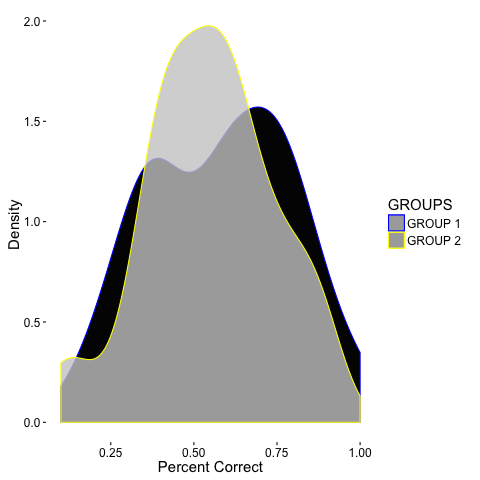

In [359]:
%%R 

cols <- c("GROUP 1"="blue","GROUP 2"="yellow")

#histrogram
ggplot(wordseg.m, (aes(x=value))) +
#   geom_density(data=subset(wordseg.m, age_group == 1),color="black", fill = "gray1") +
#   geom_density(data=subset(wordseg.m, age_group == 2),color="black", fill = "gray80", alpha = .8) +
  geom_density(data=subset(wordseg.m, age_group == 1), fill = "gray1", aes(colour="GROUP 1")) +
  geom_density(data=subset(wordseg.m, age_group == 2), fill = "gray80", alpha = .8, aes(colour="GROUP 2")) +
  scale_colour_manual(name="GROUPS",values=cols) +
  scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic() +
  theme(text = element_text(size = 15)) +
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Graph by session 1 and 2, non_words

In [26]:
%R sess_ws.m <- melt(summary,id.vars='age_group', measure.vars=c('non_w_s_1_v_all','non_w_s_2_v_all'))
%R head(sess_ws.m)

,age_group,variable,value
1,1.0,non_w_s_1_v_all,0.375
2,1.0,non_w_s_1_v_all,0.600
3,1.0,non_w_s_1_v_all,0.600
4,1.0,non_w_s_1_v_all,0.300
5,1.0,non_w_s_1_v_all,0.875
6,1.0,non_w_s_1_v_all,0.875


#### Accuracy by Sess, non_words

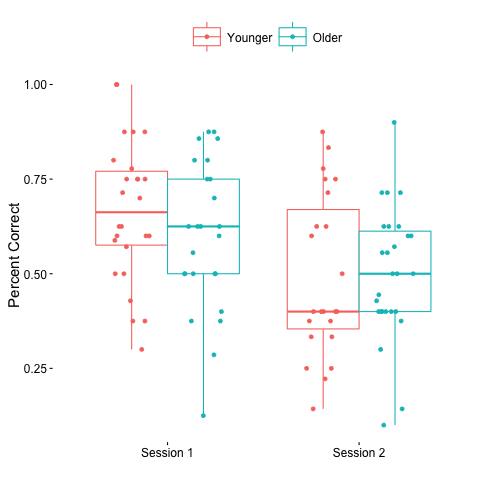

In [27]:
%%R
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))

#### Learning scores by session, version and age, non_words

In [28]:
%%R
#one sample t-test (regarless of version, age, session), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 3.2143, df = 102, p-value = 0.001751
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5245962 0.6038750
sample estimates:
mean of x 
0.5642356 



In [29]:
%%R
#one sample t-test session 1 all (both versions, both ages), 50% chance 
t.test(summary$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_1_v_all
t = 4.9302, df = 50, p-value = 9.455e-06
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5788493 0.6872627
sample estimates:
mean of x 
 0.633056 



In [30]:
%%R
#one sample t-test session 2 all (both versions, both ages), 50% chance 
t.test(summary$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_2_v_all
t = -0.13051, df = 49, p-value = 0.8967
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4420856 0.5508509
sample estimates:
mean of x 
0.4964683 



In [31]:
%%R
#one sample t-test version 1 (both session, both ages), 50% chance
t.test(summary$non_w_s_all_v_1, mu=.5)


	One Sample t-test

data:  summary$non_w_s_all_v_1
t = 2.6766, df = 48, p-value = 0.01015
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5202804 0.6427420
sample estimates:
mean of x 
0.5815112 



In [32]:
%%R
#one sample t-test version 2 (both session, both ages), 50% chance
t.test(summary$non_w_s_all_v_2, mu=.5)


	One Sample t-test

data:  summary$non_w_s_all_v_2
t = 1.7042, df = 52, p-value = 0.09432
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4919364 0.5989291
sample estimates:
mean of x 
0.5454328 



In [33]:
%%R
#one sample t-test version 1, session 1 (both ages), 50% chance
t.test(summary$non_w_s_1_v_1, mu=.5)


	One Sample t-test

data:  summary$non_w_s_1_v_1
t = 2.6676, df = 29, p-value = 0.01237
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5241636 0.6829792
sample estimates:
mean of x 
0.6035714 



In [34]:
%%R
#one sample t-test version 2, session 1 (both ages), 50% chance
t.test(summary$non_w_s_1_v_2, mu=.5)


	One Sample t-test

data:  summary$non_w_s_1_v_2
t = 4.6453, df = 22, p-value = 0.0001248
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5887058 0.7317910
sample estimates:
mean of x 
0.6602484 



In [35]:
%%R
#one sample t-test session 1, younger (both versions)
t.test(younger$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  younger$non_w_s_1_v_all
t = 4.5457, df = 25, p-value = 0.000121
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5905641 0.7406127
sample estimates:
mean of x 
0.6655884 



In [36]:
%%R
#one sample t-test session 1, older (both versions)
t.test(older$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  older$non_w_s_1_v_all
t = 2.5087, df = 24, p-value = 0.01928
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5175914 0.6808531
sample estimates:
mean of x 
0.5992222 



In [37]:
%%R
#one sample t-test session 2, younger (both versions)
t.test(younger$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  younger$non_w_s_2_v_all
t = -0.16365, df = 22, p-value = 0.8715
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4002144 0.5851893
sample estimates:
mean of x 
0.4927019 



In [38]:
%%R
#one sample t-test session 2, older (both versions)
t.test(older$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  older$non_w_s_2_v_all
t = -0.0096553, df = 26, p-value = 0.9924
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4308406 0.5685127
sample estimates:
mean of x 
0.4996767 



### Part Words Percent Correct

In [39]:
# prepare PART WORD data 
%R wordseg.m <- melt(summary,id.vars='age_group', measure.vars=c('part_w_s_1_v_1','part_w_s_1_v_2','part_w_s_2_v_1','part_w_s_2_v_2'))
%R head(wordseg.m)

,age_group,variable,value
1,1.0,part_w_s_1_v_1,0.25
2,1.0,part_w_s_1_v_1,NaN
3,1.0,part_w_s_1_v_1,NaN
4,1.0,part_w_s_1_v_1,NaN
5,1.0,part_w_s_1_v_1,1.00
6,1.0,part_w_s_1_v_1,0.75


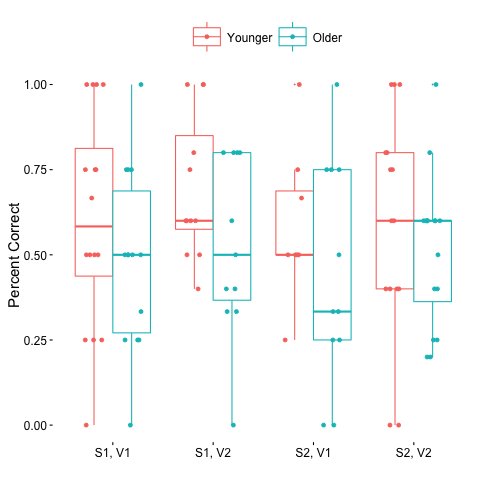

In [40]:
%%R
#accuracy by Sess and Vers
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=wordseg.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("S1, V1","S1, V2", "S2, V1","S2, V2"))+
  theme(text = element_text(size = 15))

#### Average percent correct, part_words

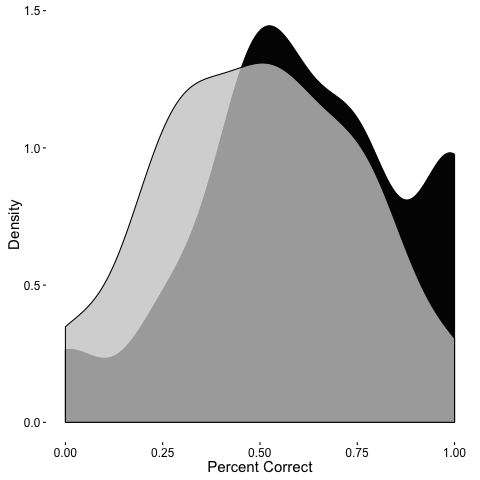

In [41]:
%%R
#histrogram
ggplot(wordseg.m, (aes(x=value)))+
  geom_density(data=subset(wordseg.m, age_group == 1),color="black", fill = "gray1")+
  geom_density(data=subset(wordseg.m, age_group == 2),color="black", fill = "gray80", alpha = .8)+
  scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Graph by session 1 and 2, part_words

In [42]:
# prepare word seg data
%R sess_pw.m <- melt(summary,id.vars='age_group', measure.vars=c('part_w_s_1_v_all','part_w_s_2_v_all'))
%R head(sess_pw.m)

,age_group,variable,value
1,1.0,part_w_s_1_v_all,0.25
2,1.0,part_w_s_1_v_all,0.50
3,1.0,part_w_s_1_v_all,0.60
4,1.0,part_w_s_1_v_all,0.60
5,1.0,part_w_s_1_v_all,1.00
6,1.0,part_w_s_1_v_all,0.75


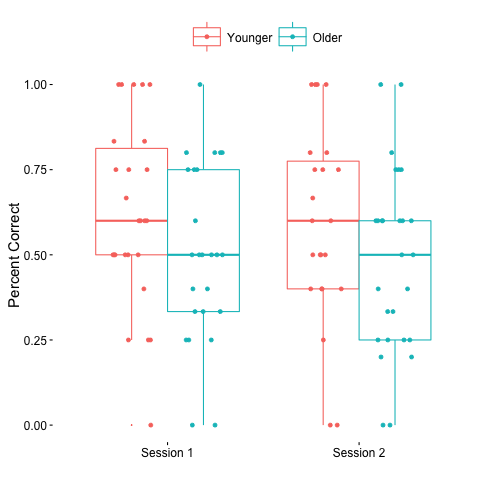

In [43]:
%%R
#accuracy by Sess and Vers
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=sess_pw.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))

#### Learning scores by session, version and age, part_words

In [44]:
%%R
#one sample t-test (regarless of version, age, session), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 2.0736, df = 102, p-value = 0.04064
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5024462 0.6101752
sample estimates:
mean of x 
0.5563107 



In [45]:
%%R
#one sample t-test session 1 all (both versions, both ages), 50% chance 
t.test(summary$part_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$part_w_s_1_v_all
t = 1.6948, df = 50, p-value = 0.09633
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4882627 0.6385347
sample estimates:
mean of x 
0.5633987 



In [46]:
%%R
#one sample t-test session 2 all (both versions, both ages), 50% chance 
t.test(summary$part_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$part_w_s_2_v_all
t = 0.85326, df = 49, p-value = 0.3977
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4543762 0.6129571
sample estimates:
mean of x 
0.5336667 



In [47]:
%%R
#one sample t-test version 1 (both session, both ages), 50% chance
t.test(summary$part_w_s_all_v_1, mu=.5)


	One Sample t-test

data:  summary$part_w_s_all_v_1
t = 0.78109, df = 48, p-value = 0.4386
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4491347 0.6154912
sample estimates:
mean of x 
0.5323129 



In [48]:
%%R
#one sample t-test version 2 (both session, both ages), 50% chance
t.test(summary$part_w_s_all_v_2, mu=.5)


	One Sample t-test

data:  summary$part_w_s_all_v_2
t = 2.0598, df = 52, p-value = 0.04444
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5019301 0.6477555
sample estimates:
mean of x 
0.5748428 



In [49]:
%%R
#one sample t-test version 1, session 1 (both ages), 50% chance
t.test(summary$part_w_s_1_v_1, mu=.5)


	One Sample t-test

data:  summary$part_w_s_1_v_1
t = 0.93639, df = 29, p-value = 0.3568
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4407914 0.6592086
sample estimates:
mean of x 
     0.55 



In [50]:
%%R
#one sample t-test version 2, session 1 (both ages), 50% chance
t.test(summary$part_w_s_1_v_2, mu=.5)


	One Sample t-test

data:  summary$part_w_s_1_v_2
t = 2.2023, df = 22, p-value = 0.03843
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5066329 0.7209033
sample estimates:
mean of x 
0.6137681 



In [51]:
%%R
#one sample t-test session 1, younger (both versions)
t.test(younger$part_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  younger$part_w_s_1_v_all
t = 2.2918, df = 25, p-value = 0.03062
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5122112 0.7288144
sample estimates:
mean of x 
0.6205128 



In [52]:
%%R
#one sample t-test session 1, older (both versions)
t.test(older$part_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  older$part_w_s_1_v_all
t = 0.07751, df = 24, p-value = 0.9389
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.3974896 0.6105104
sample estimates:
mean of x 
    0.504 



In [53]:
%%R
#one sample t-test session 2, younger (both versions)
t.test(younger$part_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  younger$part_w_s_2_v_all
t = 1.4933, df = 22, p-value = 0.1496
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4650654 0.7146448
sample estimates:
mean of x 
0.5898551 



In [54]:
%%R
#one sample t-test session 2, older (both versions)
t.test(older$part_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  older$part_w_s_2_v_all
t = -0.27674, df = 26, p-value = 0.7842
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.3803490 0.5912559
sample estimates:
mean of x 
0.4858025 



### order_TP33 Percent Correct

In [55]:
# prepare TP33 data 
%R wordseg.m <- melt(summary,id.vars='age_group', measure.vars=c('order_TP33_s_1_v_1','order_TP33_s_1_v_2','order_TP33_s_2_v_1','order_TP33_s_2_v_2'))
%R head(wordseg.m)

,age_group,variable,value
1,1.0,order_TP33_s_1_v_1,0.666667
2,1.0,order_TP33_s_1_v_1,NaN
3,1.0,order_TP33_s_1_v_1,NaN
4,1.0,order_TP33_s_1_v_1,NaN
5,1.0,order_TP33_s_1_v_1,0.333333
6,1.0,order_TP33_s_1_v_1,0.666667


#### Accuracy by Sess and Vers, order_TP33

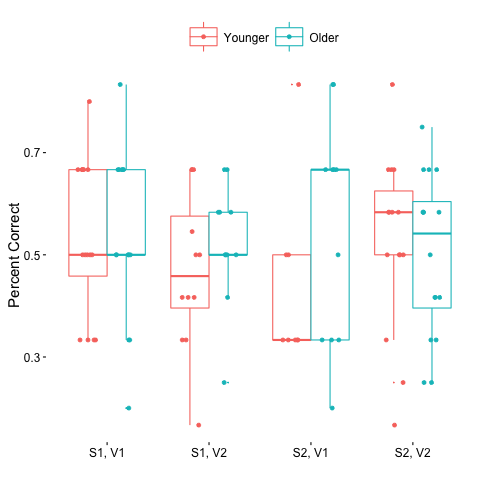

In [56]:
%%R
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=wordseg.m) +
  geom_boxplot(outlier.size = 0) +
  #geom_boxplot() +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("S1, V1","S1, V2", "S2, V1","S2, V2"))+
  theme(text = element_text(size = 15))

#### Average percent correct, order_TP33

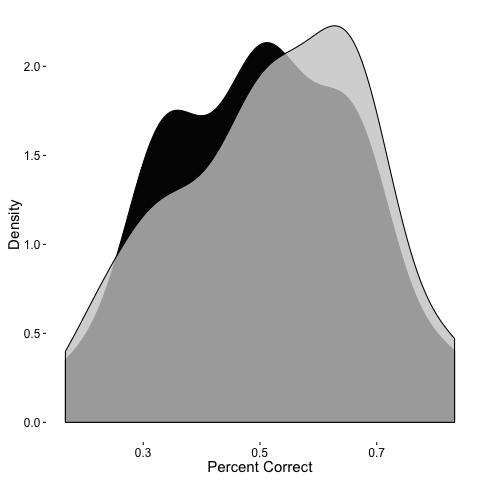

In [57]:
%%R
#histrogram
ggplot(wordseg.m, (aes(x=value)))+
  geom_density(data=subset(wordseg.m, age_group == 1),color="black", fill = "gray1")+
  geom_density(data=subset(wordseg.m, age_group == 2),color="black", fill = "gray80", alpha = .8)+
  scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Graph by session 1 and 2, order_TP33

In [58]:
%R sess_ws.m <- melt(summary,id.vars='age_group', measure.vars=c('order_TP33_s_1_v_all','order_TP33_s_2_v_all'))
%R head(sess_ws.m)

,age_group,variable,value
1,1.0,order_TP33_s_1_v_all,0.666667
2,1.0,order_TP33_s_1_v_all,0.666667
3,1.0,order_TP33_s_1_v_all,0.416667
4,1.0,order_TP33_s_1_v_all,0.416667
5,1.0,order_TP33_s_1_v_all,0.333333
6,1.0,order_TP33_s_1_v_all,0.666667


#### Accuracy by Session, order_TP33

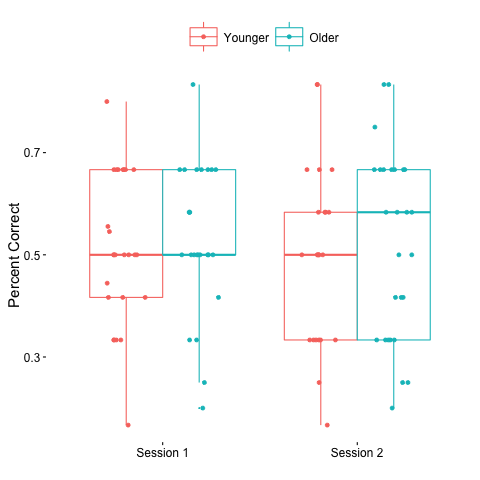

In [59]:
%%R
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))

#### Learning scores by session, version and age, order_TP33

In [60]:
%%R
#one sample t-test (regarless of version, age, session), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 0.90307, df = 102, p-value = 0.3686
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4826295 0.5464085
sample estimates:
mean of x 
 0.514519 



In [61]:
%%R
#one sample t-test session 1 all (both versions, both ages), 50% chance 
t.test(summary$order_TP33_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$order_TP33_s_1_v_all
t = 1.0075, df = 50, p-value = 0.3186
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4796310 0.5613672
sample estimates:
mean of x 
0.5204991 



In [62]:
%%R
#one sample t-test session 2 all (both versions, both ages), 50% chance 
t.test(summary$order_TP33_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$order_TP33_s_2_v_all
t = 0.35767, df = 49, p-value = 0.7221
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.458434 0.559566
sample estimates:
mean of x 
    0.509 



In [63]:
%%R
#one sample t-test version 1 (both session, both ages), 50% chance
t.test(summary$order_TP33_s_all_v_1, mu=.5)


	One Sample t-test

data:  summary$order_TP33_s_all_v_1
t = 0.9728, df = 48, p-value = 0.3355
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4738727 0.5751069
sample estimates:
mean of x 
0.5244898 



In [64]:
%%R
#one sample t-test version 2 (both session, both ages), 50% chance
t.test(summary$order_TP33_s_all_v_2, mu=.5)


	One Sample t-test

data:  summary$order_TP33_s_all_v_2
t = 0.19215, df = 52, p-value = 0.8484
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4622062 0.5457984
sample estimates:
mean of x 
0.5040023 



In [65]:
%%R
#one sample t-test version 1, session 1 (both ages), 50% chance
t.test(summary$order_TP33_s_1_v_1, mu=.5)


	One Sample t-test

data:  summary$order_TP33_s_1_v_1
t = 1.3537, df = 29, p-value = 0.1863
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4801354 0.5976424
sample estimates:
mean of x 
0.5388889 



In [66]:
%%R
#one sample t-test version 2, session 1 (both ages), 50% chance
t.test(summary$order_TP33_s_1_v_2, mu=.5)


	One Sample t-test

data:  summary$order_TP33_s_1_v_2
t = -0.18334, df = 22, p-value = 0.8562
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4351165 0.5543433
sample estimates:
mean of x 
0.4947299 



In [67]:
%%R
#one sample t-test session 1, younger (both versions)
t.test(younger$order_TP33_s_1_v_all, mu=.5)


	One Sample t-test

data:  younger$order_TP33_s_1_v_all
t = 0.35203, df = 25, p-value = 0.7278
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4511000 0.5690631
sample estimates:
mean of x 
0.5100816 



In [68]:
%%R
#one sample t-test session 1, older (both versions)
t.test(older$order_TP33_s_1_v_all, mu=.5)


	One Sample t-test

data:  older$order_TP33_s_1_v_all
t = 1.0676, df = 24, p-value = 0.2963
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4707584 0.5919082
sample estimates:
mean of x 
0.5313333 



In [69]:
%%R
#one sample t-test session 2, younger (both versions)
t.test(younger$order_TP33_s_2_v_all, mu=.5)


	One Sample t-test

data:  younger$order_TP33_s_2_v_all
t = -0.099325, df = 22, p-value = 0.9218
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4207259 0.5720277
sample estimates:
mean of x 
0.4963768 



In [70]:
%%R
#one sample t-test session 2, older (both versions)
t.test(older$order_TP33_s_2_v_all, mu=.5)


	One Sample t-test

data:  older$order_TP33_s_2_v_all
t = 0.56074, df = 26, p-value = 0.5798
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4473433 0.5921628
sample estimates:
mean of x 
0.5197531 



### three_1nov_1cong Percent Correct

In [71]:
%%R
# prepare 3 1-nov,1-cong data 
wordseg.m <- melt(summary,id.vars='age_group', measure.vars=c('three_1nov_1cong_s_1_v_1','three_1nov_1cong_s_1_v_2',
                                                              'three_1nov_1cong_s_2_v_1','three_1nov_1cong_s_2_v_2'))


In [72]:
%R head(wordseg.m)

,age_group,variable,value
1,1.0,three_1nov_1cong_s_1_v_1,0.333333
2,1.0,three_1nov_1cong_s_1_v_1,NaN
3,1.0,three_1nov_1cong_s_1_v_1,NaN
4,1.0,three_1nov_1cong_s_1_v_1,NaN
5,1.0,three_1nov_1cong_s_1_v_1,0.666667
6,1.0,three_1nov_1cong_s_1_v_1,0.555556


#### Accuracy by Sess and Vers, three_1nov_1cong

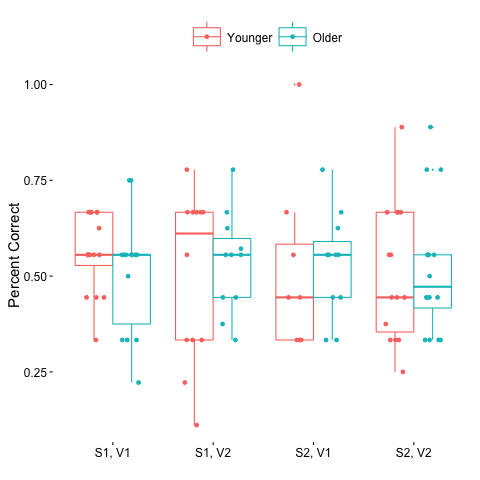

In [73]:
%%R
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=wordseg.m) +
  geom_boxplot(outlier.size = 0) +
  #geom_boxplot() +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("S1, V1","S1, V2", "S2, V1","S2, V2"))+
  theme(text = element_text(size = 15))

#### Average percent correct, three_1nov_1cong

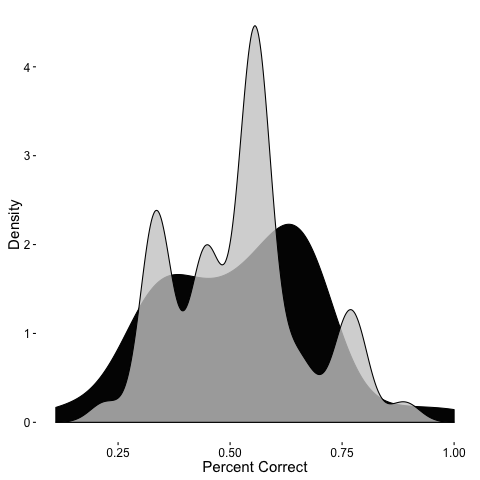

In [74]:
%%R
#histrogram
library(ggplot2)
ggplot(wordseg.m, (aes(x=value)))+
  geom_density(data=subset(wordseg.m, age_group == 1),color="black", fill = "gray1")+
  geom_density(data=subset(wordseg.m, age_group == 2),color="black", fill = "gray80", alpha = .8)+
  scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Graph by Session 1 and 2, three_1nov_1cong

In [75]:
%R sess_ws.m <- melt(summary,id.vars='age_group', measure.vars=c('three_1nov_1cong_s_1_v_all','three_1nov_1cong_s_2_v_all'))
%R head(sess_ws.m)

,age_group,variable,value
1,1.0,three_1nov_1cong_s_1_v_all,0.333333
2,1.0,three_1nov_1cong_s_1_v_all,0.555556
3,1.0,three_1nov_1cong_s_1_v_all,0.333333
4,1.0,three_1nov_1cong_s_1_v_all,0.333333
5,1.0,three_1nov_1cong_s_1_v_all,0.666667
6,1.0,three_1nov_1cong_s_1_v_all,0.555556


#### Accuracy by Session, three_1nov_1cong

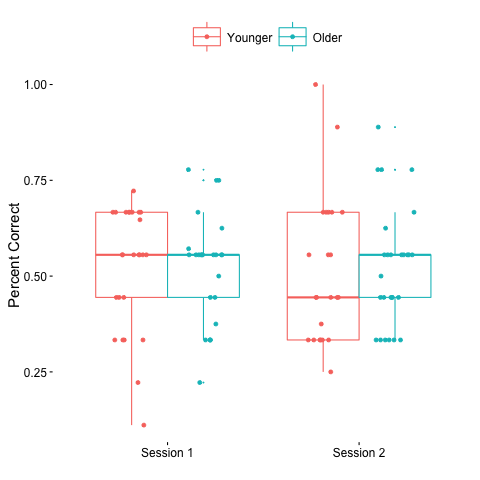

In [76]:
%%R
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))

#### Learning scores by session, version and age, three_1nov_1cong

In [77]:
%%R
#one sample t-test (regarless of version, age, session), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 1.4343, df = 102, p-value = 0.1545
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.491319 0.554027
sample estimates:
mean of x 
 0.522673 



In [78]:
%%R
#one sample t-test session 1 all (both versions, both ages), 50% chance 
t.test(summary$three_1nov_1cong_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$three_1nov_1cong_s_1_v_all
t = 1.0309, df = 50, p-value = 0.3075
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4794098 0.5640167
sample estimates:
mean of x 
0.5217133 



In [79]:
%%R
#one sample t-test session 2 all (both versions, both ages), 50% chance 
t.test(summary$three_1nov_1cong_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$three_1nov_1cong_s_2_v_all
t = 0.71267, df = 49, p-value = 0.4794
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4686591 0.5657853
sample estimates:
mean of x 
0.5172222 



In [80]:
%%R
#one sample t-test version 1 (both session, both ages), 50% chance
t.test(summary$three_1nov_1cong_s_all_v_1, mu=.5)


	One Sample t-test

data:  summary$three_1nov_1cong_s_all_v_1
t = 1.4867, df = 48, p-value = 0.1436
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4890106 0.5733477
sample estimates:
mean of x 
0.5311791 



In [81]:
%%R
#one sample t-test version 2 (both session, both ages), 50% chance
t.test(summary$three_1nov_1cong_s_all_v_2, mu=.5)


	One Sample t-test

data:  summary$three_1nov_1cong_s_all_v_2
t = 0.86094, df = 52, p-value = 0.3932
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4734670 0.5664093
sample estimates:
mean of x 
0.5199382 



In [82]:
%%R
#one sample t-test version 1, session 1 (both ages), 50% chance
t.test(summary$three_1nov_1cong_s_1_v_1, mu=.5)


	One Sample t-test

data:  summary$three_1nov_1cong_s_1_v_1
t = 1.5192, df = 29, p-value = 0.1395
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4876560 0.5836403
sample estimates:
mean of x 
0.5356481 



In [83]:
%%R
#one sample t-test version 2, session 1 (both ages), 50% chance
t.test(summary$three_1nov_1cong_s_1_v_2, mu=.5)


	One Sample t-test

data:  summary$three_1nov_1cong_s_1_v_2
t = 0.47039, df = 22, p-value = 0.6427
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4400098 0.5951869
sample estimates:
mean of x 
0.5175983 



In [84]:
%%R
#one sample t-test session 1, younger (both versions)
t.test(younger$three_1nov_1cong_s_1_v_all, mu=.5)


	One Sample t-test

data:  younger$three_1nov_1cong_s_1_v_all
t = 0.71934, df = 25, p-value = 0.4786
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4576145 0.5878857
sample estimates:
mean of x 
0.5227501 



In [85]:
%%R
#one sample t-test session 1, older (both versions)
t.test(older$three_1nov_1cong_s_1_v_all, mu=.5)


	One Sample t-test

data:  older$three_1nov_1cong_s_1_v_all
t = 0.72883, df = 24, p-value = 0.4732
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4622011 0.5790688
sample estimates:
mean of x 
0.5206349 



In [86]:
%%R
#one sample t-test session 2, younger (both versions)
t.test(younger$three_1nov_1cong_s_2_v_all, mu=.5)


	One Sample t-test

data:  younger$three_1nov_1cong_s_2_v_all
t = 0.25703, df = 22, p-value = 0.7995
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4274347 0.5930967
sample estimates:
mean of x 
0.5102657 



In [87]:
%%R
#one sample t-test session 2, older (both versions)
t.test(older$three_1nov_1cong_s_2_v_all, mu=.5)


	One Sample t-test

data:  older$three_1nov_1cong_s_2_v_all
t = 0.77796, df = 26, p-value = 0.4436
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4619856 0.5843107
sample estimates:
mean of x 
0.5231481 



### three_2nov_1cong_1incong Percent Correct

In [88]:
%%R
# prepare 3 2-nov,1-cog,1-incog data 
wordseg.m <- melt(summary,id.vars='age_group', measure.vars=c('three_2nov_1cong_1incong_s_1_v_1',
                                                              'three_2nov_1cong_1incong_s_1_v_2',
                                                              'three_2nov_1cong_1incong_s_2_v_1',
                                                              'three_2nov_1cong_1incong_s_2_v_2'))

In [89]:
%R head(wordseg.m)

,age_group,variable,value
1,1.0,three_2nov_1cong_1incong_s_1_v_1,0.600000
2,1.0,three_2nov_1cong_1incong_s_1_v_1,NaN
3,1.0,three_2nov_1cong_1incong_s_1_v_1,NaN
4,1.0,three_2nov_1cong_1incong_s_1_v_1,NaN
5,1.0,three_2nov_1cong_1incong_s_1_v_1,0.500000
6,1.0,three_2nov_1cong_1incong_s_1_v_1,0.666667


#### Accuracy by Session and Version, three_2nov_1cong_1incong

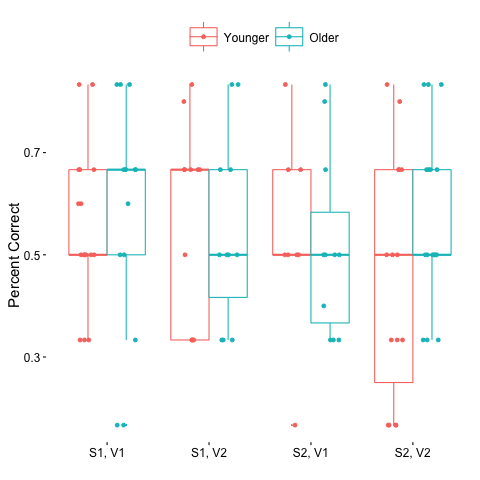

In [90]:
%%R
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=wordseg.m) +
  geom_boxplot(outlier.size = 0) +
  #geom_boxplot() +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("S1, V1","S1, V2", "S2, V1","S2, V2"))+
  theme(text = element_text(size = 15))

#### Average Percent Correct, three_2nov_1cong_1incong

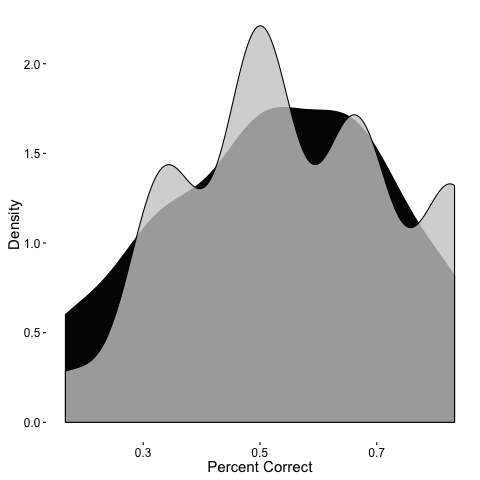

In [91]:
%%R
#histrogram
library(ggplot2)
ggplot(wordseg.m, (aes(x=value)))+
  geom_density(data=subset(wordseg.m, age_group == 1),color="black", fill = "gray1")+
  geom_density(data=subset(wordseg.m, age_group == 2),color="black", fill = "gray80", alpha = .8)+
  scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Graph by session 1 and 2, three_2nov_1cong_1incong

In [92]:
%%R
sess_ws.m <- melt(summary,id.vars='age_group', measure.vars=c('three_2nov_1cong_1incong_s_1_v_all',
                                                              'three_2nov_1cong_1incong_s_2_v_all'))

In [93]:
%R head(sess_ws.m)

,age_group,variable,value
1,1.0,three_2nov_1cong_1incong_s_1_v_all,0.600000
2,1.0,three_2nov_1cong_1incong_s_1_v_all,0.500000
3,1.0,three_2nov_1cong_1incong_s_1_v_all,0.833333
4,1.0,three_2nov_1cong_1incong_s_1_v_all,0.666667
5,1.0,three_2nov_1cong_1incong_s_1_v_all,0.500000
6,1.0,three_2nov_1cong_1incong_s_1_v_all,0.666667


#### Accuracy by session, three_2nov_1cong_1incong

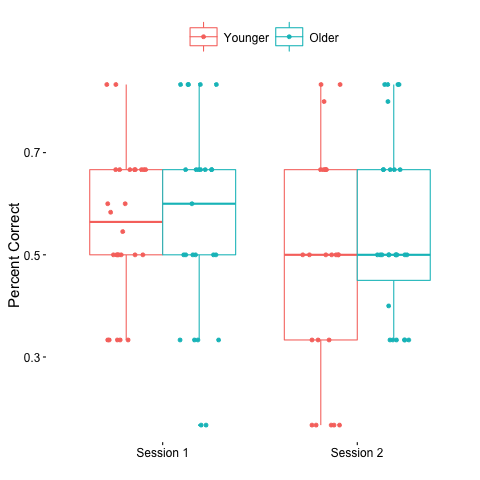

In [94]:
%%R
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))

#### Learning scores by session, version and age, three_2nov_1cong_1incong

In [95]:
%%R
#one sample t-test (regarless of version, age, session), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 2.2024, df = 102, p-value = 0.02989
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5041174 0.5787305
sample estimates:
mean of x 
0.5414239 



In [96]:
%%R
#one sample t-test session 1 all (both versions, both ages), 50% chance 
t.test(summary$three_2nov_1cong_1incong_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$three_2nov_1cong_1incong_s_1_v_all
t = 2.4878, df = 50, p-value = 0.01623
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5116923 0.6096981
sample estimates:
mean of x 
0.5606952 



In [97]:
%%R
#one sample t-test session 2 all (both versions, both ages), 50% chance 
t.test(summary$three_2nov_1cong_1incong_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$three_2nov_1cong_1incong_s_2_v_all
t = 0.71443, df = 49, p-value = 0.4783
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4637436 0.5762564
sample estimates:
mean of x 
     0.52 



In [98]:
%%R
#one sample t-test version 1 (both session, both ages), 50% chance
t.test(summary$three_2nov_1cong_1incong_s_all_v_1, mu=.5)


	One Sample t-test

data:  summary$three_2nov_1cong_1incong_s_all_v_1
t = 1.9479, df = 48, p-value = 0.05729
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4983572 0.6036836
sample estimates:
mean of x 
0.5510204 



In [99]:
%%R
#one sample t-test version 2 (both session, both ages), 50% chance
t.test(summary$three_2nov_1cong_1incong_s_all_v_2, mu=.5)


	One Sample t-test

data:  summary$three_2nov_1cong_1incong_s_all_v_2
t = 1.2746, df = 52, p-value = 0.2081
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4799539 0.5898575
sample estimates:
mean of x 
0.5349057 



In [100]:
%%R
#one sample t-test version 1, session 1 (both ages), 50% chance
t.test(summary$three_2nov_1cong_1incong_s_1_v_1, mu=.5)


	One Sample t-test

data:  summary$three_2nov_1cong_1incong_s_1_v_1
t = 1.9219, df = 29, p-value = 0.06449
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4957946 0.6353165
sample estimates:
mean of x 
0.5655556 



In [101]:
%%R
#one sample t-test version 2, session 1 (both ages), 50% chance
t.test(summary$three_2nov_1cong_1incong_s_1_v_2, mu=.5)


	One Sample t-test

data:  summary$three_2nov_1cong_1incong_s_1_v_2
t = 1.4793, df = 22, p-value = 0.1532
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4772800 0.6357635
sample estimates:
mean of x 
0.5565217 



In [102]:
%%R
#one sample t-test session 1, younger (both versions)
t.test(younger$three_2nov_1cong_1incong_s_1_v_all, mu=.5)


	One Sample t-test

data:  younger$three_2nov_1cong_1incong_s_1_v_all
t = 2.0213, df = 25, p-value = 0.05408
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4989115 0.6161235
sample estimates:
mean of x 
0.5575175 



In [103]:
%%R
#one sample t-test session 1, older (both versions)
t.test(older$three_2nov_1cong_1incong_s_1_v_all, mu=.5)


	One Sample t-test

data:  older$three_2nov_1cong_1incong_s_1_v_all
t = 1.5748, df = 24, p-value = 0.1284
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4801245 0.6478755
sample estimates:
mean of x 
    0.564 



In [104]:
%%R
#one sample t-test session 2, younger (both versions)
t.test(younger$three_2nov_1cong_1incong_s_2_v_all, mu=.5)


	One Sample t-test

data:  younger$three_2nov_1cong_1incong_s_2_v_all
t = -0.34441, df = 22, p-value = 0.7338
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.3880621 0.5800538
sample estimates:
mean of x 
 0.484058 



In [105]:
%%R
#one sample t-test session 2, older (both versions)
t.test(older$three_2nov_1cong_1incong_s_2_v_all, mu=.5)


	One Sample t-test

data:  older$three_2nov_1cong_1incong_s_2_v_all
t = 1.5177, df = 26, p-value = 0.1412
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4820635 0.6191711
sample estimates:
mean of x 
0.5506173 



### three_2nov_2cong Percent Correct

In [106]:
%%R
# prepare 3 2-nov,2-cog data 
wordseg.m <- melt(summary,id.vars='age_group', measure.vars=c('three_2nov_2cong_s_1_v_1', 'three_2nov_2cong_s_1_v_2',
                                                              'three_2nov_2cong_s_2_v_1', 'three_2nov_2cong_s_2_v_2'))

In [107]:
%R head(wordseg.m)

,age_group,variable,value
1,1.0,three_2nov_2cong_s_1_v_1,0.500000
2,1.0,three_2nov_2cong_s_1_v_1,NaN
3,1.0,three_2nov_2cong_s_1_v_1,NaN
4,1.0,three_2nov_2cong_s_1_v_1,NaN
5,1.0,three_2nov_2cong_s_1_v_1,0.500000
6,1.0,three_2nov_2cong_s_1_v_1,0.666667


#### Accuracy by Session and Version, three_2nov_2cong

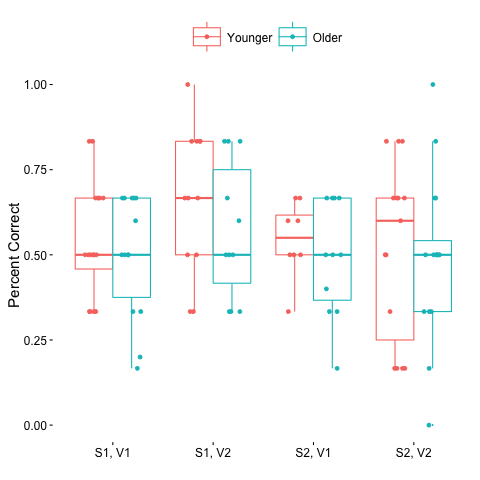

In [108]:
%%R
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=wordseg.m) +
  geom_boxplot(outlier.size = 0) +
  #geom_boxplot() +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("S1, V1","S1, V2", "S2, V1","S2, V2"))+
  theme(text = element_text(size = 15))

#### Average percent correct, three_2nov_2cong

In [1]:
%%R
#histrogram
ggplot(wordseg.m, (aes(x=value)))+
  geom_density(data=subset(wordseg.m, age_group == 1),color="black", fill = "gray1")+
  geom_density(data=subset(wordseg.m, age_group == 2),color="black", fill = "gray80", alpha = .8)+
  scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

ERROR: Cell magic `%%R` not found.


#### Graph by session 1 and 2, three_2nov_2cong

In [110]:
%%R
sess_ws.m <- melt(summary,id.vars='age_group', measure.vars=c('three_2nov_2cong_s_1_v_all',
                                                              'three_2nov_2cong_s_2_v_all'))

In [111]:
%R head(sess_ws.m)

,age_group,variable,value
1,1.0,three_2nov_2cong_s_1_v_all,0.500000
2,1.0,three_2nov_2cong_s_1_v_all,0.833333
3,1.0,three_2nov_2cong_s_1_v_all,0.666667
4,1.0,three_2nov_2cong_s_1_v_all,0.833333
5,1.0,three_2nov_2cong_s_1_v_all,0.500000
6,1.0,three_2nov_2cong_s_1_v_all,0.666667


#### Accuracy by Session, three_2nov_2cong

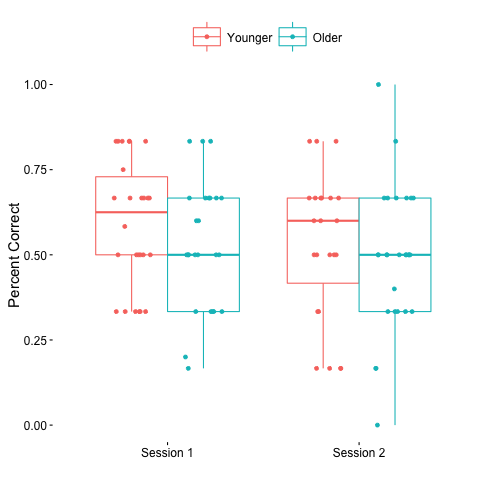

In [112]:
%%R
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(age_group)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),legend.background = element_blank(),
        legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))

### Learning scores by session, version and age

In [113]:
%%R
#one sample t-test (regarless of version, age, session), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 1.8336, df = 102, p-value = 0.06963
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4970106 0.5761285
sample estimates:
mean of x 
0.5365696 



In [114]:
%%R
#one sample t-test session 1 all (both versions, both ages), 50% chance 
t.test(summary$three_2nov_2cong_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$three_2nov_2cong_s_1_v_all
t = 2.2986, df = 50, p-value = 0.02574
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5075874 0.6126741
sample estimates:
mean of x 
0.5601307 



In [115]:
%%R
#one sample t-test session 2 all (both versions, both ages), 50% chance 
t.test(summary$three_2nov_2cong_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$three_2nov_2cong_s_2_v_all
t = 0.24606, df = 49, p-value = 0.8067
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4474411 0.5672256
sample estimates:
mean of x 
0.5073333 



In [116]:
%%R
#one sample t-test version 1 (both session, both ages), 50% chance
t.test(summary$three_2nov_2cong_s_all_v_1, mu=.5)


	One Sample t-test

data:  summary$three_2nov_2cong_s_all_v_1
t = 0.80495, df = 48, p-value = 0.4248
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4724890 0.5642457
sample estimates:
mean of x 
0.5183673 



In [117]:
%%R
#one sample t-test version 2 (both session, both ages), 50% chance
t.test(summary$three_2nov_2cong_s_all_v_2, mu=.5)


	One Sample t-test

data:  summary$three_2nov_2cong_s_all_v_2
t = 1.6166, df = 52, p-value = 0.112
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4873274 0.6177041
sample estimates:
mean of x 
0.5525157 



In [118]:
%%R
#one sample t-test version 1, session 1 (both ages), 50% chance
t.test(summary$three_2nov_2cong_s_1_v_1, mu=.5)


	One Sample t-test

data:  summary$three_2nov_2cong_s_1_v_1
t = 0.68078, df = 29, p-value = 0.5014
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4576878 0.5845344
sample estimates:
mean of x 
0.5211111 



In [119]:
%%R
#one sample t-test version 2, session 1 (both ages), 50% chance
t.test(summary$three_2nov_2cong_s_1_v_2, mu=.5)


	One Sample t-test

data:  summary$three_2nov_2cong_s_1_v_2
t = 2.7689, df = 22, p-value = 0.0112
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5301944 0.7103854
sample estimates:
mean of x 
0.6202899 



In [120]:
%%R
#one sample t-test session 1, younger (both versions)
t.test(younger$three_2nov_2cong_s_1_v_all, mu=.5)


	One Sample t-test

data:  younger$three_2nov_2cong_s_1_v_all
t = 2.4672, df = 25, p-value = 0.02082
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5148278 0.6646594
sample estimates:
mean of x 
0.5897436 



In [121]:
%%R
#one sample t-test session 1, older (both versions)
t.test(older$three_2nov_2cong_s_1_v_all, mu=.5)


	One Sample t-test

data:  older$three_2nov_2cong_s_1_v_all
t = 0.78467, df = 24, p-value = 0.4403
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4521788 0.6064879
sample estimates:
mean of x 
0.5293333 



In [122]:
%%R
#one sample t-test session 2 all (both versions, younger), 50% chance 
t.test(younger$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  younger$non_w_s_2_v_all
t = -0.16365, df = 22, p-value = 0.8715
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4002144 0.5851893
sample estimates:
mean of x 
0.4927019 



In [123]:
%%R
#one sample t-test session 2 all (both versions, older), 50% chance 
t.test(older$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  older$non_w_s_2_v_all
t = -0.0096553, df = 26, p-value = 0.9924
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4308406 0.5685127
sample estimates:
mean of x 
0.4996767 



## CONDITION AND SESSION

In [124]:
%%R
#summary for 50Nap
cond_50nap <- subset(summary, condition=='50Nap')

#summary for 90Nap
cond_90nap <- subset(summary, condition=='90Nap')

#summary for AW
cond_aw <- subset(summary, condition=='AW')

#summary for pilot
cond_pilot <- subset(summary, condition=='pilot')

#summary for QW
cond_qw <- subset(summary, condition=='QW')

In [125]:
%R head(cond_50nap)

,participant,age_group,condition,Unnamed..3,Unnamed..4,Unnamed..5,Unnamed..6,Unnamed..7,Unnamed..8,Unnamed..9,non_w_s_2_v_1,order_TP33_s_2_v_1,part_w_s_2_v_1,three_1nov_1cong_s_2_v_1,three_2nov_1cong_1incong_s_2_v_1,three_2nov_2cong_s_2_v_1,grand_total_s_2_v_1,non_w_s_all_v_1,order_TP33_s_all_v_1,part_w_s_all_v_1,three_1nov_1cong_s_all_v_1,three_2nov_1cong_1incong_s_all_v_1,three_2nov_2cong_s_all_v_1,grand_total_s_all_v_1,non_w_s_all_v_2,order_TP33_s_all_v_2,part_w_s_all_v_2,three_1nov_1cong_s_all_v_2,three_2nov_1cong_1incong_s_all_v_2,three_2nov_2cong_s_all_v_2,grand_total_s_all_v_2,non_w_s_1_v_2,order_TP33_s_1_v_2,part_w_s_1_v_2,three_1nov_1cong_s_1_v_2,three_2nov_1cong_1incong_s_1_v_2,three_2nov_2cong_s_1_v_2,grand_total_s_1_v_2,non_w_s_1_v_all,order_TP33_s_1_v_all,part_w_s_1_v_all,three_1nov_1cong_s_1_v_all,three_2nov_1cong_1incong_s_1_v_all,three_2nov_2cong_s_1_v_all,grand_total_s_1_v_all,non_w_s_2_v_2,order_TP33_s_2_v_2,part_w_s_2_v_2,three_1nov_1cong_s_2_v_2,three_2nov_1cong_1incong_s_2_v_2,three_2nov_2cong_s_2_v_2,grand_total_s_2_v_2,non_w_all_type,order_TP33_all_type,part_w_all_type,three_1nov_1cong_all_type,three_2nov_1cong_1incong_all_type,three_2nov_2cong_all_type,grand_total_all_type,non_w_s_2_v_all,order_TP33_s_2_v_all,part_w_s_2_v_all,three_1nov_1cong_s_2_v_all,three_2nov_1cong_1incong_s_2_v_all,three_2nov_2cong_s_2_v_all,grand_total_s_2_v_all,non_w_s_1_v_1,order_TP33_s_1_v_1,part_w_s_1_v_1,three_1nov_1cong_s_1_v_1,three_2nov_1cong_1incong_s_1_v_1,three_2nov_2cong_s_1_v_1,grand_total_s_1_v_1
23,133.0,1.0,50Nap,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.714286,0.583333,0.75,0.235294,0.416667,0.583333,0.528736,0.714286,0.666667,0.75,0.111111,0.333333,0.666667,0.522727,0.714286,0.666667,0.750000,0.111111,0.333333,0.666667,0.522727,0.714286,0.500000,0.75,0.375000,0.500000,0.500000,0.534884,0.714286,0.583333,0.750000,0.235294,0.416667,0.583333,0.528736,0.714286,0.500000,0.75,0.375000,0.500000,0.500000,0.534884,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,138.0,1.0,50Nap,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.500000,0.500000,0.555556,0.500000,0.833333,0.589744,0.600000,0.166667,0.00,0.333333,0.333333,0.833333,0.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.500000,0.500000,0.555556,0.500000,0.833333,0.589744,0.600000,0.166667,0.00,0.333333,0.333333,0.833333,0.375000,0.611111,0.277778,0.222222,0.444444,0.416667,0.833333,0.471264,0.600000,0.166667,0.00,0.333333,0.333333,0.833333,0.375000,0.625000,0.500000,0.500000,0.555556,0.500000,0.833333,0.589744
26,204.0,1.0,50Nap,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.571429,0.666667,0.666667,0.444444,0.500000,0.500000,0.540541,0.222222,0.583333,0.40,0.666667,0.166667,0.600000,0.456522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.571429,0.666667,0.666667,0.444444,0.500000,0.500000,0.540541,0.222222,0.583333,0.40,0.666667,0.166667,0.600000,0.456522,0.375000,0.611111,0.500000,0.555556,0.333333,0.545455,0.493976,0.222222,0.583333,0.40,0.666667,0.166667,0.600000,0.456522,0.571429,0.666667,0.666667,0.444444,0.500000,0.500000,0.540541
36,316.0,2.0,50Nap,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.200000,0.333333,0.555556,0.166667,0.666667,0.459459,0.555556,0.666667,0.60,0.777778,0.500000,0.333333,0.595745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.200000,0.333333,0.555556,0.166667,0.666667,0.459459,0.555556,0.666667,0.60,0.777778,0.500000,0.333333,0.595745,0.588235,0.529412,0.500000,0.666667,0.333333,0.500000,0.535714,0.555556,0.666667,0.60,0.777778,0.500000,0.333333,0.595745,0.625000,0.200000,0.333333,0.555556,0.166667,0.666667,0.459459
37,317.0,2.0,50Nap,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [126]:
%R head(cond_90nap)

,participant,age_group,condition,Unnamed..3,Unnamed..4,Unnamed..5,Unnamed..6,Unnamed..7,Unnamed..8,Unnamed..9,non_w_s_2_v_1,order_TP33_s_2_v_1,part_w_s_2_v_1,three_1nov_1cong_s_2_v_1,three_2nov_1cong_1incong_s_2_v_1,three_2nov_2cong_s_2_v_1,grand_total_s_2_v_1,non_w_s_all_v_1,order_TP33_s_all_v_1,part_w_s_all_v_1,three_1nov_1cong_s_all_v_1,three_2nov_1cong_1incong_s_all_v_1,three_2nov_2cong_s_all_v_1,grand_total_s_all_v_1,non_w_s_all_v_2,order_TP33_s_all_v_2,part_w_s_all_v_2,three_1nov_1cong_s_all_v_2,three_2nov_1cong_1incong_s_all_v_2,three_2nov_2cong_s_all_v_2,grand_total_s_all_v_2,non_w_s_1_v_2,order_TP33_s_1_v_2,part_w_s_1_v_2,three_1nov_1cong_s_1_v_2,three_2nov_1cong_1incong_s_1_v_2,three_2nov_2cong_s_1_v_2,grand_total_s_1_v_2,non_w_s_1_v_all,order_TP33_s_1_v_all,part_w_s_1_v_all,three_1nov_1cong_s_1_v_all,three_2nov_1cong_1incong_s_1_v_all,three_2nov_2cong_s_1_v_all,grand_total_s_1_v_all,non_w_s_2_v_2,order_TP33_s_2_v_2,part_w_s_2_v_2,three_1nov_1cong_s_2_v_2,three_2nov_1cong_1incong_s_2_v_2,three_2nov_2cong_s_2_v_2,grand_total_s_2_v_2,non_w_all_type,order_TP33_all_type,part_w_all_type,three_1nov_1cong_all_type,three_2nov_1cong_1incong_all_type,three_2nov_2cong_all_type,grand_total_all_type,non_w_s_2_v_all,order_TP33_s_2_v_all,part_w_s_2_v_all,three_1nov_1cong_s_2_v_all,three_2nov_1cong_1incong_s_2_v_all,three_2nov_2cong_s_2_v_all,grand_total_s_2_v_all,non_w_s_1_v_1,order_TP33_s_1_v_1,part_w_s_1_v_1,three_1nov_1cong_s_1_v_1,three_2nov_1cong_1incong_s_1_v_1,three_2nov_2cong_s_1_v_1,grand_total_s_1_v_1
19,126.0,1.0,90Nap,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,0.875,0.333333,0.5,0.333333,0.166667,0.6,0.473684,0.875,0.333333,0.50,0.333333,0.166667,0.600000,0.473684,1.0,0.545455,1.0,0.666667,0.666667,0.333333,0.695652,1.0,0.545455,1.0,0.666667,0.666667,0.333333,0.695652,1.000,0.545455,1.00,0.666667,0.666667,0.333333,0.695652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.944444,0.470588,0.750000,0.500000,0.416667,0.454545,0.595238,0.875,0.333333,0.5,0.333333,0.166667,0.600000,0.473684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,129.0,1.0,90Nap,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500,0.333333,0.25,0.666667,0.833333,0.833333,0.589744,0.5,0.250000,0.8,0.444444,0.833333,0.666667,0.520833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500,0.333333,0.25,0.666667,0.833333,0.833333,0.589744,0.5,0.250000,0.8,0.444444,0.833333,0.666667,0.520833,0.500000,0.277778,0.555556,0.555556,0.833333,0.750000,0.551724,0.500,0.250000,0.8,0.444444,0.833333,0.666667,0.520833,0.500,0.333333,0.25,0.666667,0.833333,0.833333,0.589744
22,132.0,1.0,90Nap,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625,0.500000,0.25,0.666667,0.666667,0.666667,0.589744,0.4,0.666667,0.4,0.666667,0.800000,0.166667,0.531915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625,0.500000,0.25,0.666667,0.666667,0.666667,0.589744,0.4,0.666667,0.4,0.666667,0.800000,0.166667,0.531915,0.500000,0.611111,0.333333,0.666667,0.727273,0.416667,0.558140,0.400,0.666667,0.4,0.666667,0.800000,0.166667,0.531915,0.625,0.500000,0.25,0.666667,0.666667,0.666667,0.589744
27,305.0,2.0,90Nap,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625,0.500000,0.50,0.500000,0.600000,0.333333,0.513514,0.4,0.583333,0.6,0.555556,0.833333,0.166667,0.520833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625,0.500000,0.50,0.500000,0.600000,0.333333,0.513514,0.4,0.583333,0.6,0.555556,0.833333,0.166667,0.520833,0.500000,0.555556,0.555556,0.529412,0.727273,0.250000,0.517647,0.400,0.583333,0.6,0.555556,0.833333,0.166667,0.520833,0.625,0.500000,0.50,0.500000,0.600000,0.333333,0.513514
38,319.0,2.0,90Nap,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375,0.666667,0.75,0.555556,0.166667,0.333333,0.461538,0.6,0.416667,1.0,0.333333,0.333333,0.333333,0.479167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.

In [127]:
%R head(cond_aw)

,participant,age_group,condition,Unnamed..3,Unnamed..4,Unnamed..5,Unnamed..6,Unnamed..7,Unnamed..8,Unnamed..9,non_w_s_2_v_1,order_TP33_s_2_v_1,part_w_s_2_v_1,three_1nov_1cong_s_2_v_1,three_2nov_1cong_1incong_s_2_v_1,three_2nov_2cong_s_2_v_1,grand_total_s_2_v_1,non_w_s_all_v_1,order_TP33_s_all_v_1,part_w_s_all_v_1,three_1nov_1cong_s_all_v_1,three_2nov_1cong_1incong_s_all_v_1,three_2nov_2cong_s_all_v_1,grand_total_s_all_v_1,non_w_s_all_v_2,order_TP33_s_all_v_2,part_w_s_all_v_2,three_1nov_1cong_s_all_v_2,three_2nov_1cong_1incong_s_all_v_2,three_2nov_2cong_s_all_v_2,grand_total_s_all_v_2,non_w_s_1_v_2,order_TP33_s_1_v_2,part_w_s_1_v_2,three_1nov_1cong_s_1_v_2,three_2nov_1cong_1incong_s_1_v_2,three_2nov_2cong_s_1_v_2,grand_total_s_1_v_2,non_w_s_1_v_all,order_TP33_s_1_v_all,part_w_s_1_v_all,three_1nov_1cong_s_1_v_all,three_2nov_1cong_1incong_s_1_v_all,three_2nov_2cong_s_1_v_all,grand_total_s_1_v_all,non_w_s_2_v_2,order_TP33_s_2_v_2,part_w_s_2_v_2,three_1nov_1cong_s_2_v_2,three_2nov_1cong_1incong_s_2_v_2,three_2nov_2cong_s_2_v_2,grand_total_s_2_v_2,non_w_all_type,order_TP33_all_type,part_w_all_type,three_1nov_1cong_all_type,three_2nov_1cong_1incong_all_type,three_2nov_2cong_all_type,grand_total_all_type,non_w_s_2_v_all,order_TP33_s_2_v_all,part_w_s_2_v_all,three_1nov_1cong_s_2_v_all,three_2nov_1cong_1incong_s_2_v_all,three_2nov_2cong_s_2_v_all,grand_total_s_2_v_all,non_w_s_1_v_1,order_TP33_s_1_v_1,part_w_s_1_v_1,three_1nov_1cong_s_1_v_1,three_2nov_1cong_1incong_s_1_v_1,three_2nov_2cong_s_1_v_1,grand_total_s_1_v_1
21,131.0,1.0,AW,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,0.500000,0.75,0.444444,0.500000,0.333333,0.538462,0.400000,0.833333,0.400000,0.666667,0.166667,0.166667,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,0.500000,0.750000,0.444444,0.500000,0.333333,0.538462,0.4,0.833333,0.4,0.666667,0.166667,0.166667,0.500000,0.555556,0.722222,0.555556,0.555556,0.333333,0.250000,0.517241,0.400000,0.833333,0.40,0.666667,0.166667,0.166667,0.500000,0.750000,0.500000,0.75,0.444444,0.500000,0.333333,0.538462
24,136.0,1.0,AW,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.333333,1.00,0.625000,0.333333,0.500000,0.485714,0.666667,0.666667,0.800000,0.666667,0.800000,1.000000,0.739130,0.666667,0.666667,0.800000,0.666667,0.800000,1.000000,0.739130,0.588235,0.555556,0.833333,0.647059,0.545455,0.750000,0.629630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.588235,0.555556,0.833333,0.647059,0.545455,0.750000,0.629630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.333333,1.00,0.625000,0.333333,0.500000,0.485714
42,325.0,2.0,AW,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.500000,0.25,0.333333,0.666667,0.500000,0.461538,0.900000,0.583333,0.600000,0.444444,0.666667,0.666667,0.645833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.500000,0.250000,0.333333,0.666667,0.500000,0.461538,0.9,0.583333,0.6,0.444444,0.666667,0.666667,0.645833,0.722222,0.555556,0.444444,0.388889,0.666667,0.583333,0.563218,0.900000,0.583333,0.60,0.444444,0.666667,0.666667,0.645833,0.500000,0.500000,0.25,0.333333,0.666667,0.500000,0.461538
50,358.0,2.0,AW,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,0.500000,0.666667,0.25,0.555556,0.5,0.166667,0.461538,0.500000,0.666667,0.25,0.555556,0.500000,0.166667,0.461538,0.700000,0.500000,0.800000,0.555556,0.333333,0.833333,0.604167,0.700000,0.500000,0.800000,0.555556,0.333333,0.833333,0.604167,0.700000,0.500000,0.800000,0.555556,0.333333,0.833333,0.604167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.611111,0.555556,0.555556,0.555556,0.416667,0.500000,0.540230,0.500000,0.666667,0.25,0.555556,0.500000,0.166667,0.461538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,362.0,2.0,AW,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,0.428571,0.666667,0.25,0.625000,0.8,0.400000,0.542857,0.428571,0.666667,0.25,0.62500

In [128]:
%R head(cond_pilot)

,participant,age_group,condition,Unnamed..3,Unnamed..4,Unnamed..5,Unnamed..6,Unnamed..7,Unnamed..8,Unnamed..9,non_w_s_2_v_1,order_TP33_s_2_v_1,part_w_s_2_v_1,three_1nov_1cong_s_2_v_1,three_2nov_1cong_1incong_s_2_v_1,three_2nov_2cong_s_2_v_1,grand_total_s_2_v_1,non_w_s_all_v_1,order_TP33_s_all_v_1,part_w_s_all_v_1,three_1nov_1cong_s_all_v_1,three_2nov_1cong_1incong_s_all_v_1,three_2nov_2cong_s_all_v_1,grand_total_s_all_v_1,non_w_s_all_v_2,order_TP33_s_all_v_2,part_w_s_all_v_2,three_1nov_1cong_s_all_v_2,three_2nov_1cong_1incong_s_all_v_2,three_2nov_2cong_s_all_v_2,grand_total_s_all_v_2,non_w_s_1_v_2,order_TP33_s_1_v_2,part_w_s_1_v_2,three_1nov_1cong_s_1_v_2,three_2nov_1cong_1incong_s_1_v_2,three_2nov_2cong_s_1_v_2,grand_total_s_1_v_2,non_w_s_1_v_all,order_TP33_s_1_v_all,part_w_s_1_v_all,three_1nov_1cong_s_1_v_all,three_2nov_1cong_1incong_s_1_v_all,three_2nov_2cong_s_1_v_all,grand_total_s_1_v_all,non_w_s_2_v_2,order_TP33_s_2_v_2,part_w_s_2_v_2,three_1nov_1cong_s_2_v_2,three_2nov_1cong_1incong_s_2_v_2,three_2nov_2cong_s_2_v_2,grand_total_s_2_v_2,non_w_all_type,order_TP33_all_type,part_w_all_type,three_1nov_1cong_all_type,three_2nov_1cong_1incong_all_type,three_2nov_2cong_all_type,grand_total_all_type,non_w_s_2_v_all,order_TP33_s_2_v_all,part_w_s_2_v_all,three_1nov_1cong_s_2_v_all,three_2nov_1cong_1incong_s_2_v_all,three_2nov_2cong_s_2_v_all,grand_total_s_2_v_all,non_w_s_1_v_1,order_TP33_s_1_v_1,part_w_s_1_v_1,three_1nov_1cong_s_1_v_1,three_2nov_1cong_1incong_s_1_v_1,three_2nov_2cong_s_1_v_1,grand_total_s_1_v_1
28,307.0,2.0,pilot,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,0.625000,0.333333,0.75,0.444444,0.500000,0.500000,0.512821,0.625000,0.333333,0.75,0.444444,0.500000,0.500000,0.512821,0.800,0.666667,0.40,0.444444,0.833333,0.833333,0.666667,0.800,0.666667,0.4,0.444444,0.833333,0.833333,0.666667,0.800,0.666667,0.40,0.444444,0.833333,0.833333,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.722222,0.555556,0.555556,0.444444,0.666667,0.666667,0.597701,0.625000,0.333333,0.75,0.444444,0.500000,0.500000,0.512821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,309.0,2.0,pilot,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,0.714286,0.666667,0.00,0.777778,0.333333,0.666667,0.611111,0.714286,0.666667,0.00,0.777778,0.333333,0.666667,0.611111,0.875,0.500000,0.00,0.375000,0.500000,0.333333,0.488372,0.875,0.500000,0.0,0.375000,0.500000,0.333333,0.488372,0.875,0.500000,0.00,0.375000,0.500000,0.333333,0.488372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800000,0.555556,0.000000,0.588235,0.416667,0.500000,0.544304,0.714286,0.666667,0.00,0.777778,0.333333,0.666667,0.611111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,310.0,2.0,pilot,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400,0.250000,0.20,0.333333,0.333333,0.500000,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,0.250000,0.20,0.333333,0.333333,0.500000,0.333333,0.400000,0.250000,0.200000,0.333333,0.333333,0.500000,0.333333,0.400000,0.250000,0.20,0.333333,0.333333,0.500000,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,312.0,2.0,pilot,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,0.571429,0.833333,1.00,0.444444,0.400000,0.666667,0.611111,0.571429,0.833333,1.00,0.444444,0.400000,0.666667,0.611111,0.875,0.250000,0.80,0.571429,0.333333,0.600000,0.600000,0.875,0.250000,0.8,0.571429,0.333333,0.600000,0.600000,0.875,0.250000,0.80,0.571429,0.333333,0.600000,0.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.733333,0.600000,0.875000,0.500000,0.363636,0.636364,0.605634,0.571429,0.833333,1.00,0.444444,0.400000,0.666667,0.611111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,313.0,2.0,pilot,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.666667,0.50,0.555556,0.333333,0.166667,0.461538,0.400,0.416667,0.60,0.333333,0.833333,0.500000,0.479167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500,0.666667,0.50,0

In [129]:
%R head(cond_qw)

,participant,age_group,condition,Unnamed..3,Unnamed..4,Unnamed..5,Unnamed..6,Unnamed..7,Unnamed..8,Unnamed..9,non_w_s_2_v_1,order_TP33_s_2_v_1,part_w_s_2_v_1,three_1nov_1cong_s_2_v_1,three_2nov_1cong_1incong_s_2_v_1,three_2nov_2cong_s_2_v_1,grand_total_s_2_v_1,non_w_s_all_v_1,order_TP33_s_all_v_1,part_w_s_all_v_1,three_1nov_1cong_s_all_v_1,three_2nov_1cong_1incong_s_all_v_1,three_2nov_2cong_s_all_v_1,grand_total_s_all_v_1,non_w_s_all_v_2,order_TP33_s_all_v_2,part_w_s_all_v_2,three_1nov_1cong_s_all_v_2,three_2nov_1cong_1incong_s_all_v_2,three_2nov_2cong_s_all_v_2,grand_total_s_all_v_2,non_w_s_1_v_2,order_TP33_s_1_v_2,part_w_s_1_v_2,three_1nov_1cong_s_1_v_2,three_2nov_1cong_1incong_s_1_v_2,three_2nov_2cong_s_1_v_2,grand_total_s_1_v_2,non_w_s_1_v_all,order_TP33_s_1_v_all,part_w_s_1_v_all,three_1nov_1cong_s_1_v_all,three_2nov_1cong_1incong_s_1_v_all,three_2nov_2cong_s_1_v_all,grand_total_s_1_v_all,non_w_s_2_v_2,order_TP33_s_2_v_2,part_w_s_2_v_2,three_1nov_1cong_s_2_v_2,three_2nov_1cong_1incong_s_2_v_2,three_2nov_2cong_s_2_v_2,grand_total_s_2_v_2,non_w_all_type,order_TP33_all_type,part_w_all_type,three_1nov_1cong_all_type,three_2nov_1cong_1incong_all_type,three_2nov_2cong_all_type,grand_total_all_type,non_w_s_2_v_all,order_TP33_s_2_v_all,part_w_s_2_v_all,three_1nov_1cong_s_2_v_all,three_2nov_1cong_1incong_s_2_v_all,three_2nov_2cong_s_2_v_all,grand_total_s_2_v_all,non_w_s_1_v_1,order_TP33_s_1_v_1,part_w_s_1_v_1,three_1nov_1cong_s_1_v_1,three_2nov_1cong_1incong_s_1_v_1,three_2nov_2cong_s_1_v_1,grand_total_s_1_v_1
1,101.0,1.0,QW,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375,0.666667,0.25,0.333333,0.600000,0.500000,0.447368,0.400,0.583333,1.0,0.888889,0.666667,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375,0.666667,0.25,0.333333,0.600000,0.500000,0.447368,0.400,0.583333,1.0,0.888889,0.666667,0.666667,0.666667,0.388889,0.611111,0.666667,0.611111,0.636364,0.583333,0.569767,0.400,0.583333,1.00,0.888889,0.666667,0.666667,0.666667,0.375,0.666667,0.25,0.333333,0.600000,0.500000,0.447368
2,102.0,1.0,QW,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,0.75,0.333333,0.75,1.000000,0.500000,0.333333,0.641026,0.750,0.333333,0.75,1.000000,0.500000,0.333333,0.641026,0.600,0.666667,0.5,0.555556,0.500000,0.833333,0.617021,0.6,0.666667,0.5,0.555556,0.500000,0.833333,0.617021,0.600,0.666667,0.50,0.555556,0.500000,0.833333,0.617021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,0.555556,0.625000,0.777778,0.500000,0.583333,0.627907,0.750,0.333333,0.75,1.000000,0.500000,0.333333,0.641026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,103.0,1.0,QW,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,0.25,0.500000,0.50,0.555556,0.666667,0.500000,0.487179,0.250,0.500000,0.50,0.555556,0.666667,0.500000,0.487179,0.600,0.416667,0.6,0.333333,0.833333,0.666667,0.541667,0.6,0.416667,0.6,0.333333,0.833333,0.666667,0.541667,0.600,0.416667,0.60,0.333333,0.833333,0.666667,0.541667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444444,0.444444,0.555556,0.444444,0.750000,0.583333,0.517241,0.250,0.500000,0.50,0.555556,0.666667,0.500000,0.487179,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,104.0,1.0,QW,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300,0.416667,0.6,0.333333,0.666667,0.833333,0.479167,0.3,0.416667,0.6,0.333333,0.666667,0.833333,0.479167,0.300,0.416667,0.60,0.333333,0.666667,0.833333,0.479167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300000,0.416667,0.600000,0.333333,0.666667,0.833333,0.479167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,105.0,1.0,QW,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875,0.333333,1.00,0.666667,0.500000,0.500000,0.641026,0.400,0.583333,0.6,0.444444,0.666667,0.833333,0.562500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875,0.333333,1.00,0.666667,0.500000,0.500000,0.641026,0.400,0.583333,0.6,0.444444,0.

#### Non words percent correct

In [130]:
%R wordseg.m <- melt(summary,id.vars='condition', measure.vars=c('non_w_s_1_v_all','non_w_s_2_v_all'))
%R head(wordseg.m)

,condition,variable,value
1,QW,non_w_s_1_v_all,0.375
2,QW,non_w_s_1_v_all,0.600
3,QW,non_w_s_1_v_all,0.600
4,QW,non_w_s_1_v_all,0.300
5,QW,non_w_s_1_v_all,0.875
6,QW,non_w_s_1_v_all,0.875


#### Accuracy by Session

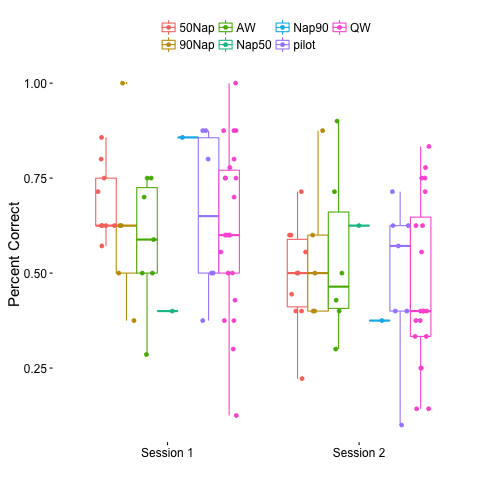

In [131]:
%%R
sess_ws.m <- melt(summary,id.vars='condition', measure.vars=c('non_w_s_1_v_all','non_w_s_2_v_all'))
#accuracy by Sess and Vers
library(Hmisc)
library(ggplot2)
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(condition)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  #scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),
        legend.background = element_blank(),legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))


In [132]:
%%R
options(repr.plot.width=20, repr.plot.height=10)

#### Average Percent Correct, non words

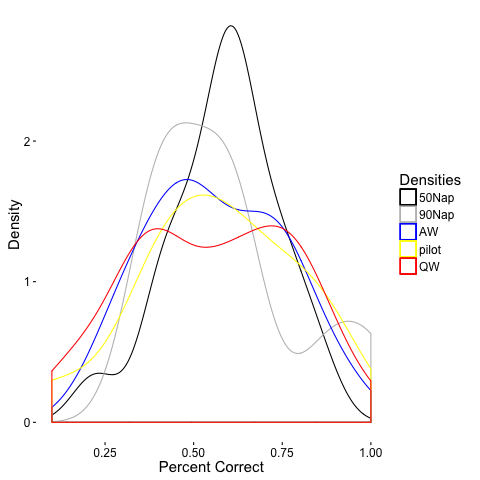

In [133]:
%%R
m <- ggplot(wordseg.m, aes(x = value))
m + geom_density(data=subset(wordseg.m, condition == '50Nap'), aes(colour="50Nap"))+
geom_density(data=subset(wordseg.m, condition == '90Nap'), aes(colour="90Nap"))+
geom_density(data=subset(wordseg.m, condition == 'AW'), aes(colour="AW"))+
geom_density(data=subset(wordseg.m, condition == 'pilot'), aes(colour="pilot"))+
geom_density(data=subset(wordseg.m, condition == 'QW'), aes(colour="QW"))+
scale_colour_manual(values=c("50Nap"="black", "90Nap"="grey", "AW"="blue", "pilot"="yellow", "QW"="red"), name="Densities") +
scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Learning scores by session

In [134]:
%%R
#one sample t-test (regarless of version, age, condition), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 3.239, df = 100, p-value = 0.001629
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5253556 0.6055209
sample estimates:
mean of x 
0.5654383 



In [135]:
%%R
#one sample t-test session 1 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_1_v_all
t = 4.9302, df = 50, p-value = 9.455e-06
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5788493 0.6872627
sample estimates:
mean of x 
 0.633056 



In [136]:
%%R
#one sample t-test session 2 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_2_v_all
t = -0.13051, df = 49, p-value = 0.8967
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4420856 0.5508509
sample estimates:
mean of x 
0.4964683 



In [137]:
%%R
#one sample t-test session 1, 50Nap (both versions)
t.test(cond_50nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_50nap$non_w_s_1_v_all
t = 5.822, df = 8, p-value = 0.0003951
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.6135934 0.7625971
sample estimates:
mean of x 
0.6880952 



In [138]:
%%R
#one sample t-test session 1, 90Nap (both versions)
t.test(cond_90nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_90nap$non_w_s_1_v_all
t = 1.1952, df = 4, p-value = 0.298
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.3346324 0.9153676
sample estimates:
mean of x 
    0.625 



In [139]:
%%R
#one sample t-test session 1, AW (both versions)
t.test(cond_aw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_aw$non_w_s_1_v_all
t = 1.2826, df = 6, p-value = 0.247
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4255671 0.7384185
sample estimates:
mean of x 
0.5819928 



In [140]:
%%R
#one sample t-test session 1, pilot (both versions)
t.test(cond_pilot$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_pilot$non_w_s_1_v_all
t = 1.7085, df = 5, p-value = 0.1482
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4222101 0.8861232
sample estimates:
mean of x 
0.6541667 



In [141]:
%%R
#one sample t-test session 1, QW (both versions)
t.test(cond_qw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_qw$non_w_s_1_v_all
t = 2.6598, df = 21, p-value = 0.01466
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5268889 0.7196479
sample estimates:
mean of x 
0.6232684 



### Part Words Percent Correct

In [142]:
# prepare PART WORD data 
%R wordseg.m <- melt(summary,id.vars='condition', measure.vars=c('part_w_s_1_v_all','part_w_s_2_v_all'))
%R head(wordseg.m)

,condition,variable,value
1,QW,part_w_s_1_v_all,0.25
2,QW,part_w_s_1_v_all,0.50
3,QW,part_w_s_1_v_all,0.60
4,QW,part_w_s_1_v_all,0.60
5,QW,part_w_s_1_v_all,1.00
6,QW,part_w_s_1_v_all,0.75


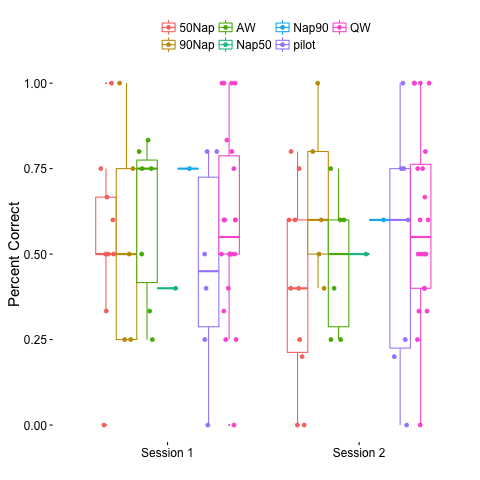

In [143]:
%%R
sess_ws.m <- melt(summary,id.vars='condition', measure.vars=c('part_w_s_1_v_all','part_w_s_2_v_all'))
#accuracy by Sess
library(Hmisc)
library(ggplot2)
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(condition)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  #scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),
        legend.background = element_blank(),legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))


#### Average percent correct, part words

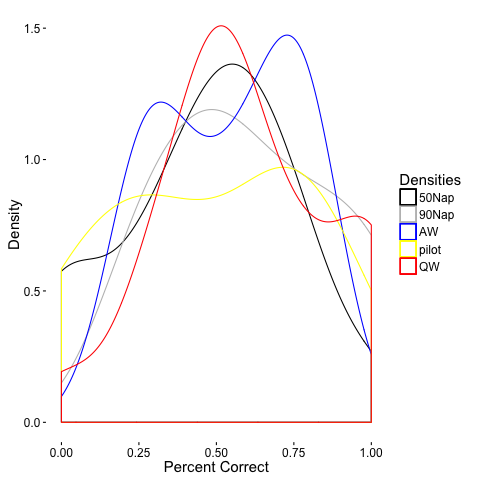

In [144]:
%%R
m <- ggplot(wordseg.m, aes(x = value))
m + geom_density(data=subset(wordseg.m, condition == '50Nap'), aes(colour="50Nap"))+
geom_density(data=subset(wordseg.m, condition == '90Nap'), aes(colour="90Nap"))+
geom_density(data=subset(wordseg.m, condition == 'AW'), aes(colour="AW"))+
geom_density(data=subset(wordseg.m, condition == 'pilot'), aes(colour="pilot"))+
geom_density(data=subset(wordseg.m, condition == 'QW'), aes(colour="QW"))+
scale_colour_manual(values=c("50Nap"="black", "90Nap"="grey", "AW"="blue", "pilot"="yellow", "QW"="red"), name="Densities") +
scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Learning scores by session, part words

In [145]:
%%R
#one sample t-test (regarless of version, age, condition), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 1.7978, df = 100, p-value = 0.07522
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4949603 0.6023994
sample estimates:
mean of x 
0.5486799 



In [146]:
%%R
#one sample t-test session 1 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_1_v_all
t = 4.9302, df = 50, p-value = 9.455e-06
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5788493 0.6872627
sample estimates:
mean of x 
 0.633056 



In [147]:
%%R
#one sample t-test session 2 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_2_v_all
t = -0.13051, df = 49, p-value = 0.8967
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4420856 0.5508509
sample estimates:
mean of x 
0.4964683 



In [148]:
%%R
#one sample t-test session 1, 50Nap (both versions)
t.test(cond_50nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_50nap$non_w_s_1_v_all
t = 5.822, df = 8, p-value = 0.0003951
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.6135934 0.7625971
sample estimates:
mean of x 
0.6880952 



In [149]:
%%R
#one sample t-test session 1, 90Nap (both versions)
t.test(cond_90nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_90nap$non_w_s_1_v_all
t = 1.1952, df = 4, p-value = 0.298
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.3346324 0.9153676
sample estimates:
mean of x 
    0.625 



In [150]:
%%R
#one sample t-test session 1, AW (both versions)
t.test(cond_aw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_aw$non_w_s_1_v_all
t = 1.2826, df = 6, p-value = 0.247
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4255671 0.7384185
sample estimates:
mean of x 
0.5819928 



In [151]:
%%R
#one sample t-test session 1, pilot (both versions)
t.test(cond_pilot$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_pilot$non_w_s_1_v_all
t = 1.7085, df = 5, p-value = 0.1482
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4222101 0.8861232
sample estimates:
mean of x 
0.6541667 



In [152]:
%%R
#one sample t-test session 1, QW (both versions)
t.test(cond_qw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_qw$non_w_s_1_v_all
t = 2.6598, df = 21, p-value = 0.01466
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5268889 0.7196479
sample estimates:
mean of x 
0.6232684 



### order_TP33 Percent Correct

In [153]:
# prepare PART WORD data 
%R wordseg.m <- melt(summary,id.vars='condition', measure.vars=c('order_TP33_s_1_v_all','order_TP33_s_2_v_all'))
%R head(wordseg.m)

,condition,variable,value
1,QW,order_TP33_s_1_v_all,0.666667
2,QW,order_TP33_s_1_v_all,0.666667
3,QW,order_TP33_s_1_v_all,0.416667
4,QW,order_TP33_s_1_v_all,0.416667
5,QW,order_TP33_s_1_v_all,0.333333
6,QW,order_TP33_s_1_v_all,0.666667


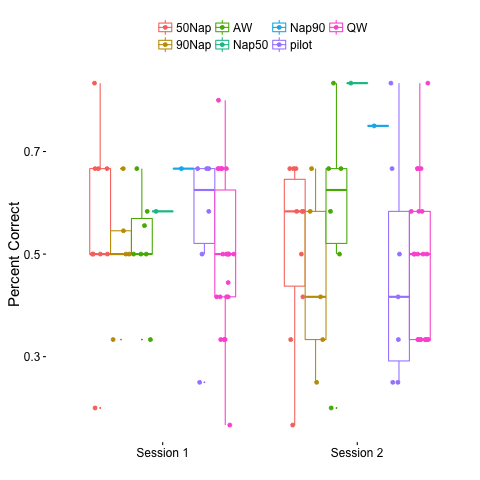

In [154]:
%%R
sess_ws.m <- melt(summary,id.vars='condition', measure.vars=c('order_TP33_s_1_v_all','order_TP33_s_2_v_all'))
#accuracy by Sess
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(condition)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  #scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),
        legend.background = element_blank(),legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))

#### Average Percent correct, Order_TP33

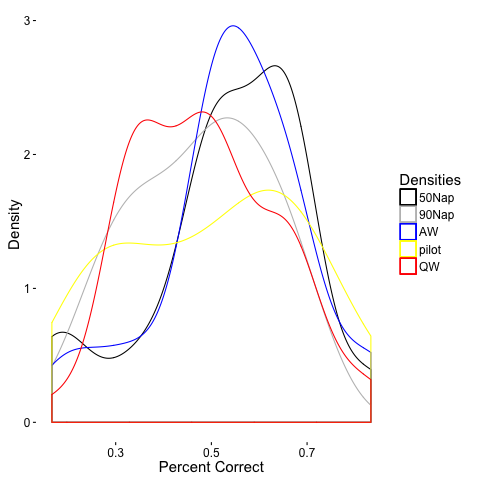

In [155]:
%%R
m <- ggplot(wordseg.m, aes(x = value))
m + geom_density(data=subset(wordseg.m, condition == '50Nap'), aes(colour="50Nap"))+
geom_density(data=subset(wordseg.m, condition == '90Nap'), aes(colour="90Nap"))+
geom_density(data=subset(wordseg.m, condition == 'AW'), aes(colour="AW"))+
geom_density(data=subset(wordseg.m, condition == 'pilot'), aes(colour="pilot"))+
geom_density(data=subset(wordseg.m, condition == 'QW'), aes(colour="QW"))+
scale_colour_manual(values=c("50Nap"="black", "90Nap"="grey", "AW"="blue", "pilot"="yellow", "QW"="red"), name="Densities") +
scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Learning scores by session, order_TP33

In [156]:
%%R
#one sample t-test (regarless of version, age, condition), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 0.92102, df = 100, p-value = 0.3593
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4829119 0.5467011
sample estimates:
mean of x 
0.5148065 



In [157]:
%%R
#one sample t-test session 1 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_1_v_all
t = 4.9302, df = 50, p-value = 9.455e-06
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5788493 0.6872627
sample estimates:
mean of x 
 0.633056 



In [158]:
%%R
#one sample t-test session 2 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_2_v_all
t = -0.13051, df = 49, p-value = 0.8967
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4420856 0.5508509
sample estimates:
mean of x 
0.4964683 



In [159]:
%%R
#one sample t-test session 1, 50Nap (both versions)
t.test(cond_50nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_50nap$non_w_s_1_v_all
t = 5.822, df = 8, p-value = 0.0003951
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.6135934 0.7625971
sample estimates:
mean of x 
0.6880952 



In [160]:
%%R
#one sample t-test session 1, 90Nap (both versions)
t.test(cond_90nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_90nap$non_w_s_1_v_all
t = 1.1952, df = 4, p-value = 0.298
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.3346324 0.9153676
sample estimates:
mean of x 
    0.625 



In [161]:
%%R
#one sample t-test session 1, AW (both versions)
t.test(cond_aw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_aw$non_w_s_1_v_all
t = 1.2826, df = 6, p-value = 0.247
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4255671 0.7384185
sample estimates:
mean of x 
0.5819928 



In [162]:
%%R
#one sample t-test session 1, pilot (both versions)
t.test(cond_pilot$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_pilot$non_w_s_1_v_all
t = 1.7085, df = 5, p-value = 0.1482
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4222101 0.8861232
sample estimates:
mean of x 
0.6541667 



In [163]:
%%R
#one sample t-test session 1, QW (both versions)
t.test(cond_qw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_qw$non_w_s_1_v_all
t = 2.6598, df = 21, p-value = 0.01466
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5268889 0.7196479
sample estimates:
mean of x 
0.6232684 



### three_1nov_1cong Percent Correct

In [164]:
# prepare PART WORD data 
%R wordseg.m <- melt(summary,id.vars='condition', measure.vars=c('three_1nov_1cong_s_1_v_all','three_1nov_1cong_s_2_v_all'))
%R head(wordseg.m)

,condition,variable,value
1,QW,three_1nov_1cong_s_1_v_all,0.333333
2,QW,three_1nov_1cong_s_1_v_all,0.555556
3,QW,three_1nov_1cong_s_1_v_all,0.333333
4,QW,three_1nov_1cong_s_1_v_all,0.333333
5,QW,three_1nov_1cong_s_1_v_all,0.666667
6,QW,three_1nov_1cong_s_1_v_all,0.555556


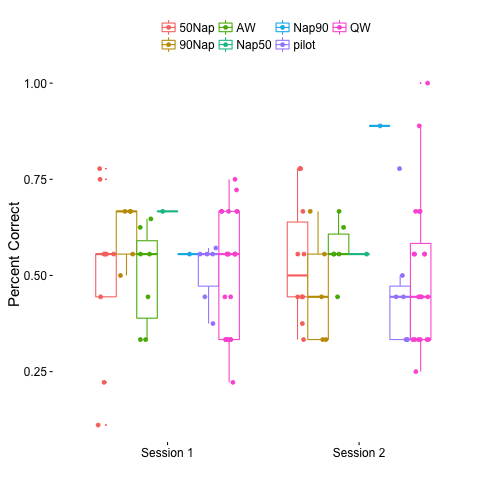

In [165]:
%%R
sess_ws.m <- melt(summary,id.vars='condition', measure.vars=c('three_1nov_1cong_s_1_v_all','three_1nov_1cong_s_2_v_all'))
#accuracy by Sess
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(condition)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  #scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),
        legend.background = element_blank(),legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))

#### Average Percent correct, three_1nov_1cong

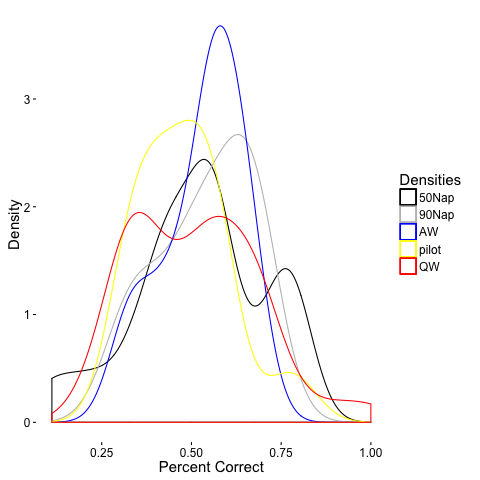

In [166]:
%%R
m <- ggplot(wordseg.m, aes(x = value))
m + geom_density(data=subset(wordseg.m, condition == '50Nap'), aes(colour="50Nap"))+
geom_density(data=subset(wordseg.m, condition == '90Nap'), aes(colour="90Nap"))+
geom_density(data=subset(wordseg.m, condition == 'AW'), aes(colour="AW"))+
geom_density(data=subset(wordseg.m, condition == 'pilot'), aes(colour="pilot"))+
geom_density(data=subset(wordseg.m, condition == 'QW'), aes(colour="QW"))+
scale_colour_manual(values=c("50Nap"="black", "90Nap"="grey", "AW"="blue", "pilot"="yellow", "QW"="red"), name="Densities") +
scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Learning scores by session, three_1nov_1cong

In [167]:
%%R
#one sample t-test (regarless of version, age, condition), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 1.2236, df = 100, p-value = 0.224
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4878889 0.5510910
sample estimates:
mean of x 
  0.51949 



In [168]:
%%R
#one sample t-test session 1 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_1_v_all
t = 4.9302, df = 50, p-value = 9.455e-06
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5788493 0.6872627
sample estimates:
mean of x 
 0.633056 



In [169]:
%%R
#one sample t-test session 2 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_2_v_all
t = -0.13051, df = 49, p-value = 0.8967
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4420856 0.5508509
sample estimates:
mean of x 
0.4964683 



In [170]:
%%R
#one sample t-test session 1, 50Nap (both versions)
t.test(cond_50nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_50nap$non_w_s_1_v_all
t = 5.822, df = 8, p-value = 0.0003951
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.6135934 0.7625971
sample estimates:
mean of x 
0.6880952 



In [171]:
%%R
#one sample t-test session 1, 90Nap (both versions)
t.test(cond_90nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_90nap$non_w_s_1_v_all
t = 1.1952, df = 4, p-value = 0.298
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.3346324 0.9153676
sample estimates:
mean of x 
    0.625 



In [172]:
%%R
#one sample t-test session 1, AW (both versions)
t.test(cond_aw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_aw$non_w_s_1_v_all
t = 1.2826, df = 6, p-value = 0.247
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4255671 0.7384185
sample estimates:
mean of x 
0.5819928 



In [173]:
%%R
#one sample t-test session 1, pilot (both versions)
t.test(cond_pilot$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_pilot$non_w_s_1_v_all
t = 1.7085, df = 5, p-value = 0.1482
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4222101 0.8861232
sample estimates:
mean of x 
0.6541667 



In [174]:
%%R
#one sample t-test session 1, QW (both versions)
t.test(cond_qw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_qw$non_w_s_1_v_all
t = 2.6598, df = 21, p-value = 0.01466
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5268889 0.7196479
sample estimates:
mean of x 
0.6232684 



### three_2nov_1cong_1incong Percent Correct

In [175]:
# prepare PART WORD data 
%R wordseg.m <- melt(summary,id.vars='condition', measure.vars=c('three_2nov_1cong_1incong_s_1_v_all','three_2nov_1cong_1incong_s_2_v_all'))
%R head(wordseg.m)

,condition,variable,value
1,QW,three_2nov_1cong_1incong_s_1_v_all,0.600000
2,QW,three_2nov_1cong_1incong_s_1_v_all,0.500000
3,QW,three_2nov_1cong_1incong_s_1_v_all,0.833333
4,QW,three_2nov_1cong_1incong_s_1_v_all,0.666667
5,QW,three_2nov_1cong_1incong_s_1_v_all,0.500000
6,QW,three_2nov_1cong_1incong_s_1_v_all,0.666667


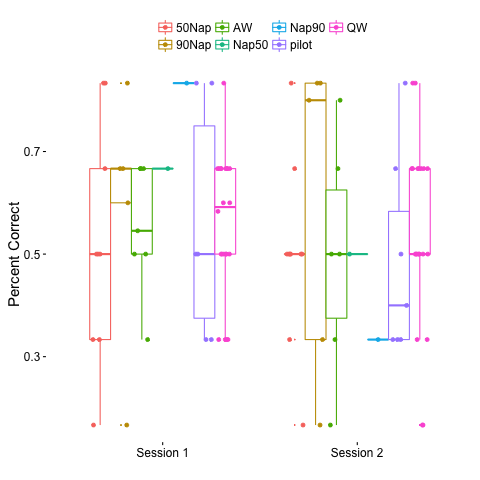

In [176]:
%%R
sess_ws.m <- melt(summary,id.vars='condition', measure.vars=c('three_2nov_1cong_1incong_s_1_v_all','three_2nov_1cong_1incong_s_2_v_all'))
#accuracy by Sess
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(condition)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  #scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),
        legend.background = element_blank(),legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))

#### Average Percent correct, three_2nov_1cong_1incong

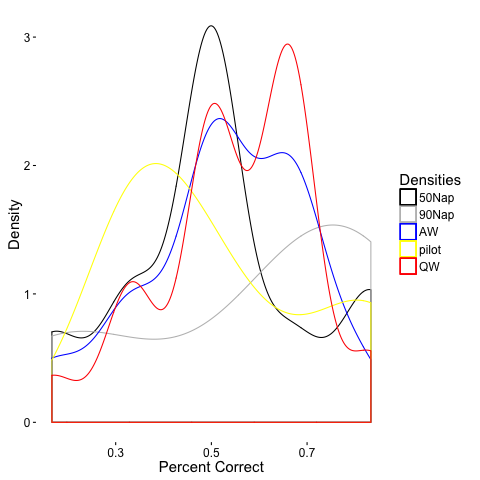

In [177]:
%%R
m <- ggplot(wordseg.m, aes(x = value))
m + geom_density(data=subset(wordseg.m, condition == '50Nap'), aes(colour="50Nap"))+
geom_density(data=subset(wordseg.m, condition == '90Nap'), aes(colour="90Nap"))+
geom_density(data=subset(wordseg.m, condition == 'AW'), aes(colour="AW"))+
geom_density(data=subset(wordseg.m, condition == 'pilot'), aes(colour="pilot"))+
geom_density(data=subset(wordseg.m, condition == 'QW'), aes(colour="QW"))+
scale_colour_manual(values=c("50Nap"="black", "90Nap"="grey", "AW"="blue", "pilot"="yellow", "QW"="red"), name="Densities") +
scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Learning scores by session, three_2nov_1cong_1incong

In [178]:
%%R
#one sample t-test (regarless of version, age, condition), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 2.1846, df = 100, p-value = 0.03125
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5037243 0.5773738
sample estimates:
mean of x 
0.5405491 



In [179]:
%%R
#one sample t-test session 1 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_1_v_all
t = 4.9302, df = 50, p-value = 9.455e-06
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5788493 0.6872627
sample estimates:
mean of x 
 0.633056 



In [180]:
%%R
#one sample t-test session 2 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_2_v_all
t = -0.13051, df = 49, p-value = 0.8967
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4420856 0.5508509
sample estimates:
mean of x 
0.4964683 



In [181]:
%%R
#one sample t-test session 1, 50Nap (both versions)
t.test(cond_50nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_50nap$non_w_s_1_v_all
t = 5.822, df = 8, p-value = 0.0003951
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.6135934 0.7625971
sample estimates:
mean of x 
0.6880952 



In [182]:
%%R
#one sample t-test session 1, 90Nap (both versions)
t.test(cond_90nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_90nap$non_w_s_1_v_all
t = 1.1952, df = 4, p-value = 0.298
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.3346324 0.9153676
sample estimates:
mean of x 
    0.625 



In [183]:
%%R
#one sample t-test session 1, AW (both versions)
t.test(cond_aw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_aw$non_w_s_1_v_all
t = 1.2826, df = 6, p-value = 0.247
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4255671 0.7384185
sample estimates:
mean of x 
0.5819928 



In [184]:
%%R
#one sample t-test session 1, pilot (both versions)
t.test(cond_pilot$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_pilot$non_w_s_1_v_all
t = 1.7085, df = 5, p-value = 0.1482
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4222101 0.8861232
sample estimates:
mean of x 
0.6541667 



In [185]:
%%R
#one sample t-test session 1, QW (both versions)
t.test(cond_qw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_qw$non_w_s_1_v_all
t = 2.6598, df = 21, p-value = 0.01466
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5268889 0.7196479
sample estimates:
mean of x 
0.6232684 



### three_2nov_2cong Percent Correct

In [186]:
# prepare PART WORD data 
%R wordseg.m <- melt(summary,id.vars='condition', measure.vars=c('three_2nov_2cong_s_1_v_all','three_2nov_2cong_s_2_v_all'))
%R head(wordseg.m)

,condition,variable,value
1,QW,three_2nov_2cong_s_1_v_all,0.500000
2,QW,three_2nov_2cong_s_1_v_all,0.833333
3,QW,three_2nov_2cong_s_1_v_all,0.666667
4,QW,three_2nov_2cong_s_1_v_all,0.833333
5,QW,three_2nov_2cong_s_1_v_all,0.500000
6,QW,three_2nov_2cong_s_1_v_all,0.666667


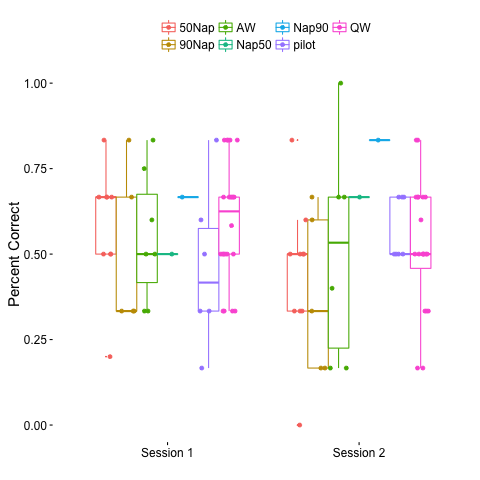

In [187]:
%%R
sess_ws.m <- melt(summary,id.vars='condition', measure.vars=c('three_2nov_2cong_s_1_v_all','three_2nov_2cong_s_2_v_all'))
#accuracy by Sess
ggplot(aes(x = as.factor(variable),y = value, colour = as.factor(condition)),data=sess_ws.m) +
  geom_boxplot(outlier.size = 0) +
  geom_point(position = position_jitterdodge())+
  #scale_y_continuous(limits = c(0,3)) +
  #scale_colour_discrete(guide = guide_legend(keywidth=2.5,keyheight=2.5), labels=c("Younger","Older")) +
  theme_classic() +
  theme(axis.title.x = element_text(),axis.title.y = element_text(),
        legend.background = element_blank(),legend.title = element_blank(),legend.position = 'top')+ 
  ylab(label = "Percent Correct")+
  scale_x_discrete("", labels=c("Session 1","Session 2"))+
  theme(text = element_text(size = 15))

#### Average Percent correct, three_2nov_2cong

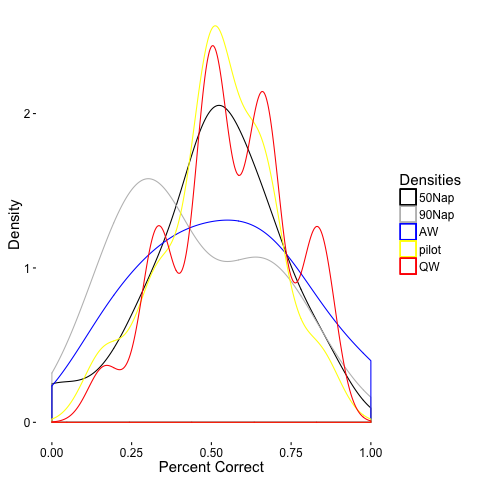

In [188]:
%%R
m <- ggplot(wordseg.m, aes(x = value))
m + geom_density(data=subset(wordseg.m, condition == '50Nap'), aes(colour="50Nap"))+
geom_density(data=subset(wordseg.m, condition == '90Nap'), aes(colour="90Nap"))+
geom_density(data=subset(wordseg.m, condition == 'AW'), aes(colour="AW"))+
geom_density(data=subset(wordseg.m, condition == 'pilot'), aes(colour="pilot"))+
geom_density(data=subset(wordseg.m, condition == 'QW'), aes(colour="QW"))+
scale_colour_manual(values=c("50Nap"="black", "90Nap"="grey", "AW"="blue", "pilot"="yellow", "QW"="red"), name="Densities") +
scale_y_continuous("Density") +
  scale_x_continuous("Percent Correct") +
  theme_classic()+
  theme(text = element_text(size = 15))+
  theme(axis.title.x = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=15))

#### Learning scores by session, three_2nov_2cong

In [189]:
%%R
#one sample t-test (regarless of version, age, condition), 50% chance 
t.test(wordseg.m$value, mu=.5)


	One Sample t-test

data:  wordseg.m$value
t = 1.7099, df = 100, p-value = 0.09038
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4945523 0.5734345
sample estimates:
mean of x 
0.5339934 



In [190]:
%%R
#one sample t-test session 1 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_1_v_all
t = 4.9302, df = 50, p-value = 9.455e-06
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5788493 0.6872627
sample estimates:
mean of x 
 0.633056 



In [191]:
%%R
#one sample t-test session 2 all (both versions, all conditions), 50% chance 
t.test(summary$non_w_s_2_v_all, mu=.5)


	One Sample t-test

data:  summary$non_w_s_2_v_all
t = -0.13051, df = 49, p-value = 0.8967
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4420856 0.5508509
sample estimates:
mean of x 
0.4964683 



In [192]:
%%R
#one sample t-test session 1, 50Nap (both versions)
t.test(cond_50nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_50nap$non_w_s_1_v_all
t = 5.822, df = 8, p-value = 0.0003951
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.6135934 0.7625971
sample estimates:
mean of x 
0.6880952 



In [193]:
%%R
#one sample t-test session 1, 90Nap (both versions)
t.test(cond_90nap$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_90nap$non_w_s_1_v_all
t = 1.1952, df = 4, p-value = 0.298
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.3346324 0.9153676
sample estimates:
mean of x 
    0.625 



In [194]:
%%R
#one sample t-test session 1, AW (both versions)
t.test(cond_aw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_aw$non_w_s_1_v_all
t = 1.2826, df = 6, p-value = 0.247
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4255671 0.7384185
sample estimates:
mean of x 
0.5819928 



In [195]:
%%R
#one sample t-test session 1, pilot (both versions)
t.test(cond_pilot$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_pilot$non_w_s_1_v_all
t = 1.7085, df = 5, p-value = 0.1482
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4222101 0.8861232
sample estimates:
mean of x 
0.6541667 



In [196]:
%%R
#one sample t-test session 1, QW (both versions)
t.test(cond_qw$non_w_s_1_v_all, mu=.5)


	One Sample t-test

data:  cond_qw$non_w_s_1_v_all
t = 2.6598, df = 21, p-value = 0.01466
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5268889 0.7196479
sample estimates:
mean of x 
0.6232684 

